## **Introduction**

For this project I will be analysing kicking data for the Canadian Football League with the aim of determining some insights about the factors that affect performance. Particularly I will look at whether certain stadiums are harder or easier to perform in. One particular interest is the effect of kicking indoors vs outdoors. In the CFL there is one indoor stadium located in Vancouver, British Columbia (BC). Indoor stadiums have no adverse elements such as wind or rain, or in the latter parts of the year, snow, and could potentially have a positive effect on the performance of kickers and punters in the stadium. Using data gathered from the CFL website containing stats of four seasons of kicking data, I will investigate this to see if there is a significant difference in the productivity of the kicking game indoors vs outdoors, and then across all stadiums to see if there are any standouts. 

There are three types of kicking in the CFL for which stats are available: kickoffs, punts, and field goals. The two I am most interested in are field goals and punting as they would be most affected by adverse conditions but kickoffs could provide further insights as well. Field goals are where the kicker attempts to kick the ball from the ground through the uprights to score points and punting is when the ball is kicked out of the hand of the punter to give the ball back to the opposing team in the hopes of making the opposing team start as far back as possible. Kickoffs are from the ground as well where the goal is generally to kick the ball as far as possible to the opposing team. There is a lot less strategy involved in kickoffs making the data rather strong and straight forward as the goal is usually kick the ball as far as possible while punting there are a few more factors. 

## **Objectives**

The goal of this analysis is to determine if there are any measurable differences in kicking performances in the different types of kicks, punting, field goals and kickoffs, in CFL stadiums across the league. If any differences are found, can we determine what it is about those locations that make them favourable or unfavourable for each of the kicking types previously described. Based on the results, I will also analyse the locations to determine if there are any geographic factors across locations that can explain the differences. Specifically, does elevation, temperature, or latitude play a role in performance. I will also look at jet lag which is defined as the travel across two or more time zones to see if performances vary. 


## **Data Details**

The data obtained for this analysis is obtained directly from the cfl.ca website where statistics are for the public to view. The data was obtained using web scraping the data directly from the site in the form of a json document. The website gives the user the ability to set parameters for the statistics that they want including the what years, where the games were played, who the opponent was, and filtering the data by game, season, or player. Knowing how the url is constructed based on these parameters and filters, I built a function to download the datasets I was looking for and would save those datasets immediately to limit the need to re-download the datasets any more than necessary. While the data is public, ethically it is important to not download the data any more times than needed to reduce costs for the hosts of the data as these stats are not designed for high data usage downloading. These stats are for general browsing to fans of the league. The data obtained was for the four seasons from 2016 to 2019.

One challenge in the data acquiring process is that the downloaded data did not actually contain the stadium location data in the results. However the website allowed you to query the stats to limit the results based on the location of the games. My approach was to create a function to download a dataset for each stadium location and put this into a list. Once in the list I then could append the location to the dataset downloaded and then combine all the datasets for each location, with the data of the location included, into a final complete dataset.
The dataset had a lot of other categories not needed so they were removed as well as both the punt average and field goal percentage needed to be converted to a float from an object . 

The punting dataset contains the year, punter’s name, the location, the number of punts, total punt yards, and punt average. The field goal dataset contains the year, kicker’s name, field goals attempted, field goals made, accuracy, a breakdown of distances of the field goals made distances, and converts made and attempted. Converts are a special field goal that is attempted after a touchdown that is a specific distance. These are only worth one point so are kept as a separate statistic. Kickoffs contain all the same data as punter plus average kickoff distance for each player in each stadium. 

A second field goal dataset was obtained through a reporter in the CFL who has taken data from the CFL over the years and aggregated it himself into an excel spreadsheet. This data contains more details about the field goals than the CFL website does. In particular it improves upon the limitation of the CFL data that does not contain the distances of the field goals kicked. This data contains each field goal kicked as a separate entry, and with that the name, location, home team of the kicker and whether it was missed or made. This provides greater opportunity to build upon the initial analysis of the CFL website data. 

While the names of the players are included in the dataset, this does not pose any ethical dilemmas as player data is readily available for the public to view. The nature of the profession is to perform in public and that performance statistics are recorded to be analysed by commentators and fans alike. 


## **Import Packages**

In [2]:
import requests
import json
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
import unittest
import os
import unittest


## **Data Retrieval**
## Web Scraping

For each team code create the url to retrieve the appropriate data set.  
This is equal to the `base url + filter location = team code`  
If the `include_home` parameter is set to `True`, results will include the home kicker for each location as well.  
The `kick_category` parameter is to set whether to rertieve punting, field goal, or kickoff data. 

In [3]:
# list of all the team location acronyms for data retrieval
team_codes = ['bc', 'edm', 'cgy', 'ssk', 'wpg', 'ham', 'tor', 'ott', 'mtl']

def get_site_json(url):
   try: 
      response = requests.get(url)
      response.raise_for_status()
   except requests.HTTPError as exception:
      print('Exception: ', exception)
   else: 
      soup = BeautifulSoup(response.content, 'html.parser')
      site_json = json.loads(soup.text)
      return site_json

def get_base_url(kick_category):
   if kick_category == 'punt':
      return 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=punting&filter[season][ge]=2016&filter[punts][ge]=1&filter[location][eq]='
   elif kick_category == 'kickoff':
      return 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=punting&filter[season][ge]=2016&filter[kicks][ge]=1&filter[location][eq]='
   elif kick_category == 'field_goal':
      return 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=field_goals&filter[season][ge]=2016&filter[location][eq]='
   else:
      return None

def get_url(include_home, team, base_url):
   if include_home:
      return base_url + team + '&group_by=player'
   else:
      # if only want to include players away games (no home advantage)
      # set filter so that opposing team = team location so home player data not included
      return base_url + team + '&filter[opponent_team_abbreviation][eq]=' + team + '&group_by=player'
   

def get_game_data(team_codes, kick_category, include_home):
   # if category is punting and kickoff - add a filter so that a minumum of 1 punts is returned
   # otherwise CFL returns a dataset including every player on the roster for the game instead of just the players who had a punt
   # same issue doesn't exist for field goals so this filter not needed
   base_url = get_base_url(kick_category)
   if base_url == None:
      print('Incorrect kick category supplied')
      return
   json_data = []
   for team in team_codes:
      url = get_url(include_home, team, base_url)
      site_json = get_site_json(url)
      json_data.append(site_json)
   return json_data

In [15]:
# UNIT TESTS FOR WEB SCRAPING DATA FUNCTIONS

class TestImportGameData(unittest.TestCase):
   def test_kick_cat_fail(self):
      res = get_base_url('something')
      self.assertIsNone(res)
   def test_kick_cat_punt(self):
      res = get_base_url('punt')
      self.assertEqual(res, 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=punting&filter[season][ge]=2016&filter[punts][ge]=1&filter[location][eq]=')
   def test_get_url_home(self):
      res = get_url(True, 'ott', 'https://www.cfl.ca/')
      self.assertEqual(res, 'https://www.cfl.ca/ott&group_by=player')
   def test_get_url_away(self):
      res = get_url(False, 'ott', 'http://google.ca/')
      self.assertEqual(res, 'http://google.ca/ott&filter[opponent_team_abbreviation][eq]=ott&group_by=player')


## !! Download all the datasets !!
### Do this minimal times to reduce the load on webservers

In [ ]:
home_game_data_punt = get_game_data(team_codes, 'punt', True)
away_game_data_punt = get_game_data(team_codes, 'punt', False)

In [ ]:
home_game_data_fg = get_game_data(team_codes, 'field_goal', True)
away_game_data_fg = get_game_data(team_codes, 'field_goal', False)

In [ ]:
home_game_data_ko = get_game_data(team_codes, 'kickoff', True)
away_game_data_ko = get_game_data(team_codes, 'kickoff', False)

## Save Retrieved Data to file
### *Warning this will write to disk and overwrite any data in file location*
The data is saved to disk so that it does not to be downloaded again unnecessarily. 

In [ ]:
def save_json_to_file(data, name):
   with open(name, 'w', encoding='utf-8') as f:
      return json.dump(data, f, ensure_ascii=False, indent=3)

save_json_to_file(home_game_data_punt, 'home_game_data_punt.json')
save_json_to_file(away_game_data_punt, 'away_game_data_punt.json')
save_json_to_file(home_game_data_fg, 'home_game_data_fg.json')
save_json_to_file(away_game_data_fg, 'away_game_data_fg.json')
save_json_to_file(home_game_data_ko, 'home_game_data_ko.json')
save_json_to_file(away_game_data_ko, 'away_game_data_ko.json')


## Create DataFrames and add Locations to the datasets
The downloaded data can be filtered by location but doesn't include the location in the data itself so must be added manually  
This is needed only for the datasets obtained via the cfl webpage and webscraping  
The data obtained in an excel sheet already has location data included.

In [6]:
def getDFFromJson(data):
   df = pd.DataFrame(data['data'])
   return df


# Column headers for punt df and field goal df
punt_ko_columns = ['YEAR', 'NAME', 'LOCATION', 'URL', 'TEAM', 'GAMES_PLAYED', 'NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG', 'PUNT_LONG', 'PUNT_SINGLES', 'NUMBER_OF_KICKOFFS', 'KO_YDS', 'KO_AVG', 'KO_LG', 'KO_S']
fg_columns = ['YEAR', 'NAME', 'LOCATION', 'URL', 'TEAM', 'GAMES_PLAYED', 'FG_ATTEMPTS', 'FG_MADE', 'ACCURACY', 'LONG', 'S', 'lt_20', '20_29', '30_39', '40_49', 'gte_50', 'C1_ATT', 'C1_MADE']

def open_json_file(file_name):
   with open(file_name) as f:
      data = json.load(f)
      return data

def build_dataframe(team_codes, column_names, data):
   dn = []
   for i, team in enumerate(team_codes):
      #create df from data[i]
      df = getDFFromJson(data[i])
      #add location of game to df
      df.insert(2, 'LOCATION', team)
      #add df to df list
      dn.append(df)
   # create new df with all location dfs combined
   dn = pd.concat(dn, axis=0, )
   # add column names to df
   
   dn.columns = column_names
   return dn

def createDFwLocationFromFile(file_name, team_codes, column_names):
   #check if length of data = length of team_codes
   data = open_json_file(file_name)
   if(len(data) != len(team_codes)):
      print('Data Error: file data length does not match team code length')
      return 
   # empty array to put each stadium dfs in
   dn = build_dataframe(team_codes, column_names, data)
   return dn
      


In [7]:
df_away_punt = createDFwLocationFromFile('away_game_data_punt.json', team_codes, punt_ko_columns)
df_home_punt = createDFwLocationFromFile('home_game_data_punt.json', team_codes, punt_ko_columns)
df_away_fg = createDFwLocationFromFile('away_game_data_fg.json', team_codes, fg_columns)
df_home_fg = createDFwLocationFromFile('home_game_data_fg.json', team_codes, fg_columns)
df_away_ko = createDFwLocationFromFile('away_game_data_ko.json', team_codes, punt_ko_columns)
df_home_ko = createDFwLocationFromFile('home_game_data_ko.json', team_codes, punt_ko_columns)


In [8]:
class TestDFCreationFromJsonFile(unittest.TestCase):
   def test_open_json_file_exists(self):
      self.assertIsNotNone(open_json_file)
   def test_open_json_file(self):
      res = open_json_file('test_file.json')
      self.assertEqual(len(res), 3)
   def test_createDF_exists(self):
      self.assertIsNotNone(createDFwLocationFromFile)
   def test_build_df_exists(self):
      self.assertIsNotNone(build_dataframe)
   def test_build_df(self):
      data = open_json_file('test_file.json')
      res = build_dataframe(['ott','bc','ham'], fg_columns,  data)
      self.assertEqual(len(res.index), 3)
      self.assertEqual(res.shape, (3,18))
      self.assertEqual(res.columns[2], 'LOCATION')
      self.assertEqual(len(res.columns), 18)      
   



## Clean up the data contained in the DataFrames
### Remove unused columns and fix some data formatting and types

In [9]:
def clean_df_punt(df):
   #filter out any rows with punts < 2
   df = df[df.NUMBER_OF_PUNTS.gt(1)]
   
   #remove Kickoff columns and other columns not of interest
   df = df.drop(['URL', 'GAMES_PLAYED','PUNT_LONG', 'PUNT_SINGLES', 'NUMBER_OF_KICKOFFS', 'KO_YDS', 'KO_AVG', 'KO_LG', 'KO_S'], axis=1)

   # filter out 2021 as not a complete season
   df = df[df.YEAR.lt(2021)]

   #sort values
   df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
   df['LOCATION'] = df['LOCATION'].str.upper()

   #convert PUNT_AVG type from object to float
   df['PUNT_AVG'] = df['PUNT_AVG'].astype(float, errors = 'raise')
   return df

df_away_punt_clean = clean_df_punt(df_away_punt)
df_home_punt_clean = clean_df_punt(df_home_punt)

In [10]:
def clean_df_ko(df):
   #filter out 2021 season as in progress
   df = df[df.YEAR.lt(2021)]

   #filter out any rows with kickoffs < 1
   df = df[df.NUMBER_OF_KICKOFFS.gt(1)]

   #convert KO_AVG type from object to float
   df['KO_AVG'] = df['KO_AVG'].astype(float, errors = 'raise')

   # remove Punt columns and other columns not of interest
   df = df.drop(['URL', 'GAMES_PLAYED', 'NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG', 'PUNT_LONG', 'PUNT_SINGLES', 'KO_LG', 'KO_S'], axis=1)

   #filter out any kickoff averages less than 45 yards as there was likely a specialty kick not hit for farthest distance
   df = df[df.KO_AVG.gt(45)]

   #sort values
   df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
   df['LOCATION'] = df['LOCATION'].str.upper()

   return df
   
df_away_ko_clean = clean_df_ko(df_away_ko)
df_home_ko_clean = clean_df_ko(df_home_ko)




In [11]:
def clean_df_fg(df):
   #remove any unused columns 
   df= df.drop(['URL', 'S', 'GAMES_PLAYED', 'LONG', 'S', 'lt_20',	'20_29',	'30_39',	'40_49',	'gte_50', 'C1_ATT',	'C1_MADE'], axis=1)

   #filter out 2021 season as in progress
   df = df[df.YEAR.lt(2021)]    
   #sort values 
   df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
   df['LOCATION'] = df['LOCATION'].str.upper()

   df['ACCURACY'] = df['ACCURACY'].astype(float, errors = 'raise')
   return df

df_away_fg_clean = clean_df_fg(df_away_fg)
df_home_fg_clean = clean_df_fg(df_home_fg)

In [12]:
def clean_df_ko(df):
   #filter out 2021 season as in progress
   df = df[df.YEAR.lt(2021)]

   #filter out any rows with kickoffs < 1
   df = df[df.NUMBER_OF_KICKOFFS.gt(1)]

   #convert KO_AVG type from object to float
   df['KO_AVG'] = df['KO_AVG'].astype(float, errors = 'raise')

   # remove Punt columns and other columns not of interest
   df = df.drop(['URL', 'GAMES_PLAYED', 'NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG', 'PUNT_LONG', 'PUNT_SINGLES', 'KO_LG', 'KO_S'], axis=1)

   #filter out any kickoff averages less than 45 yards as there was likely a specialty kick not hit for farthest distance
   df = df[df.KO_AVG.gt(45)]

   #sort values
   df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
   df['LOCATION'] = df['LOCATION'].str.upper()

   return df
   
df_away_ko_clean = clean_df_ko(df_away_ko)
df_home_ko_clean = clean_df_ko(df_home_ko)




## Data Limitations

The limitations of the punt data is that punt average has limitations as a punting performance metric. The total punt yards per punt is calculated from the line of scrimmage where the play starts to where the ball is caught or picked up by the returner. If the ball lands on the ground at 30 yards which is a  punt, and gets a favourable bounce and goes an extra 30 yards, this would be recorded as a 60 yard punt or a very good punt if it was kicked exceptionally. This is where a particularly windy game can possibly have favourable results for the punter’s statistics as the wind can make it very challenging for the returner to catch the ball in the air resulting in short punts that bounce past the returner for a long punt recorded in the statistics. 

The limitations of the field goal data is that field goal accuracy depends a lot on the distance of the attempt. With punts, generally the desired outcome is to kick the ball as far as possible each time and the chance of success is not determined by where the punter is on the field. Field goals however are highly dependent on the position of the attempt. A 10 yard field goal has essentially a 100% success rate while a 55 yard attempt would be significantly lower. The data obtained from the website categorizes the successful field goalsby distance but does not show the distances of the missed attempts. This makes it difficult to account for the accuracy from different ranges which would be a more useful statistic for comparison. Even in unfavourable weather conditions outdoors, a short range field goal will likely be made every time. The longer the field goal, the greater the chance for the kick to be affected by poor weather conditions 
outdoors. 


## Get aggregate punt and kickoff averages, and field goal accuracies for each stadium
#### This is done by aggregating all field goal and punt data

For field goals all field goal attempts are summed as well as all field goals made then accuracy is calculated from these results.  

With punts the total yards punted summed is divided by the total punts to get the overall avearage.  

If I was to just take the average of the accuracy and punt averages already calculated a one punt game of 70 yards would have the same weight as a 10 punt game with an average of 45 so it is important to do it this way or else that data would be inaccurate. 


In [38]:
def get_location_punt_averages(df, group_by_column):
   total_punts = df['NUMBER_OF_PUNTS'].groupby(df[group_by_column]).sum()
   total_punt_yards = df['PUNT_YDS'].groupby(df[group_by_column]).sum()
   averages =  (total_punt_yards / total_punts).round(1)
   df = pd.DataFrame(averages, columns=['PUNT_AVG'])
   df[group_by_column] = df.index
   return df

def get_location_fg_accuracies(df, group_by_column):
   total_attempts = df['FG_ATTEMPTS'].groupby(df[group_by_column]).sum()
   total_made = df['FG_MADE'].groupby(df[group_by_column]).sum()
   accuracies = (total_made / total_attempts * 100).round(1)
   df = pd.DataFrame(accuracies, columns=['ACCURACY'])
   df[group_by_column] = df.index
   return df

def get_location_ko_averages(df, group_by_column):
   total_kos = df['NUMBER_OF_KICKOFFS'].groupby(df[group_by_column]).sum()
   total_ko_yards = df['KO_YDS'].groupby(df[group_by_column]).sum()
   averages =  (total_ko_yards / total_kos).round(1)
   df = pd.DataFrame(averages, columns=['KO_AVG'])
   df[group_by_column] = df.index
   return df

    
away_punt_avgs = get_location_punt_averages(df_away_punt_clean, 'LOCATION')
home_punt_avgs = get_location_punt_averages(df_home_punt_clean, 'LOCATION')

home_fg_accuracies = get_location_fg_accuracies(df_home_fg_clean, 'LOCATION')
away_fg_accuracies = get_location_fg_accuracies(df_away_fg_clean, 'LOCATION')

away_ko_avgs = get_location_ko_averages(df_away_ko_clean, 'LOCATION')
home_ko_avgs = get_location_ko_averages(df_home_ko_clean, 'LOCATION')



## Dataframe Validation
Test the data cleaning processes.  
Validate the data making sure that after it has been cleaned it is within valid ranges.
There are seperate test runners for each of the kick types: punt, field goals and kickoffs as each has they're own unique data properties.

In [40]:

class DFTestsKickoff(unittest.TestCase):
   def setUp(self):
      try:
         data = createDFwLocationFromFile('home_game_data_ko.json', team_codes, punt_ko_columns)
         clean_data = clean_df_ko(data)
         self.fixture = clean_data
      except IOError as e:
         print('Error:', e)

   def test_years(self):
      years = set([2016, 2017, 2018, 2019])
      df_years = self.fixture['YEAR']
      self.assertTrue(all([i in years for i in df_years]))
   
   def test_locations(self):
      teams = set(x.upper() for x in team_codes)
      df_locations = self.fixture['LOCATION']
      self.assertTrue(all([i in teams for i in df_locations]))
   
   def test_ko_quantity(self):
      df_ko_quantity = self.fixture['NUMBER_OF_KICKOFFS']
      self.assertFalse((df_ko_quantity < 1).any())
      self.assertFalse((df_ko_quantity > 100).any())
   
   def test_ko_avgs(self):
      df_ko_avgs = self.fixture['KO_AVG']
      self.assertFalse((df_ko_avgs < 40).any())
      self.assertFalse((df_ko_avgs > 90).any())
   
   def test_col_names(self):
      self.assertListEqual(list(self.fixture.columns), ['YEAR', 'NAME', 'LOCATION', 'TEAM', 'NUMBER_OF_KICKOFFS', 'KO_YDS', 'KO_AVG'])

   def test_agg_ko_df(self):
      res = get_location_ko_averages(self.fixture, 'LOCATION')
      res_avgs = res['KO_AVG']
      self.assertTrue((res['KO_AVG'] > 55).all())
      self.assertTrue((res['KO_AVG'] < 75).all())
      self.assertListEqual(list(res.columns), ['KO_AVG','LOCATION'])
      
   
class DFTestsPunt(unittest.TestCase):
   def setUp(self):
      try:
         data = createDFwLocationFromFile('away_game_data_punt.json', team_codes, punt_ko_columns)
         clean_data = clean_df_punt(data)
         self.fixture = clean_data
      except IOError as e:
         print('Error:', e)

   def test_years(self):
      years = set([2016, 2017, 2018, 2019])
      df_years = self.fixture['YEAR']
      self.assertTrue(all([i in years for i in df_years]))
   
   def test_locations(self):
      teams = set(x.upper() for x in team_codes)
      df_locations = self.fixture['LOCATION']
      self.assertTrue(all([i in teams for i in df_locations]))
   
   def test_punt_quantity(self):
      df_punt_quantity = self.fixture['NUMBER_OF_PUNTS']
      self.assertFalse((df_punt_quantity < 1).any())
      self.assertFalse((df_punt_quantity > 200).any())
   def test_punt_avgs(self):
      df_punt_avgs = self.fixture['PUNT_AVG']
      self.assertFalse((df_punt_avgs < 20).any())
      self.assertFalse((df_punt_avgs > 80).any())
   def test_col_names(self):
      self.assertListEqual(list(self.fixture.columns), ['YEAR', 'NAME', 'LOCATION', 'TEAM', 'NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG'])
   def test_agg_punt_df(self):
      res = get_location_punt_averages(self.fixture, 'LOCATION')
      res_avgs = res['PUNT_AVG']
      self.assertTrue((res['PUNT_AVG'] > 35).all())
      self.assertTrue((res['PUNT_AVG'] < 65).all())
      self.assertListEqual(list(res.columns), ['PUNT_AVG','LOCATION'])

class DFTestsFG(unittest.TestCase):
   def setUp(self):
      try:
         data = createDFwLocationFromFile('away_game_data_fg.json', team_codes, fg_columns)
         clean_data = clean_df_fg(data)
         self.fixture = clean_data
      except IOError as e:
         print('Error:', e)

   def test_years(self):
      years = set([2016, 2017, 2018, 2019])
      df_years = self.fixture['YEAR']
      self.assertTrue(all([i in years for i in df_years]))
   
   def test_locations(self):
      teams = set(x.upper() for x in team_codes)
      df_locations = self.fixture['LOCATION']
      self.assertTrue(all([i in teams for i in df_locations]))
   
   def test_attempts(self):
      df_fg_attempts = self.fixture['FG_ATTEMPTS']
      self.assertTrue((df_fg_attempts > 0).all())
      self.assertTrue((df_fg_attempts < 100).all())
   def test_col_names(self):
      self.assertListEqual(list(self.fixture.columns), ['YEAR', 'NAME', 'LOCATION', 'TEAM', 'FG_ATTEMPTS', 'FG_MADE', 'ACCURACY'])
   def test_agg_fg_df(self):
      res = get_location_fg_accuracies(self.fixture, 'LOCATION')
      res_avgs = res['ACCURACY']
      self.assertTrue((res['ACCURACY'] > 60).all())
      self.assertTrue((res['ACCURACY'] < 100).all())
      self.assertListEqual(list(res.columns), ['ACCURACY','LOCATION'])

        
unittest.main(argv=['ingored', '-v'], exit=False)

test_agg_fg_df (__main__.DFTestsFG) ... ok
test_attempts (__main__.DFTestsFG) ... ok
test_col_names (__main__.DFTestsFG) ... ok
test_locations (__main__.DFTestsFG) ... ok
test_years (__main__.DFTestsFG) ... ok
test_agg_ko_df (__main__.DFTestsKickoff) ... ok
test_col_names (__main__.DFTestsKickoff) ... ok
test_ko_avgs (__main__.DFTestsKickoff) ... ok
test_ko_quantity (__main__.DFTestsKickoff) ... ok
test_locations (__main__.DFTestsKickoff) ... ok
test_years (__main__.DFTestsKickoff) ... ok
test_agg_punt_df (__main__.DFTestsPunt) ... ok
test_col_names (__main__.DFTestsPunt) ... ok
test_locations (__main__.DFTestsPunt) ... ok
test_punt_avgs (__main__.DFTestsPunt) ... ok
test_punt_quantity (__main__.DFTestsPunt) ... ok
test_years (__main__.DFTestsPunt) ... ok
test_build_df (__main__.TestDFCreationFromJsonFile) ... ok
test_build_df_exists (__main__.TestDFCreationFromJsonFile) ... ok
test_createDF_exists (__main__.TestDFCreationFromJsonFile) ... ok
test_open_json_file (__main__.TestDFCreatio

## Preliminary visualizations and data analyis 

Plot each location with boxplots showing each year seperately.  

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

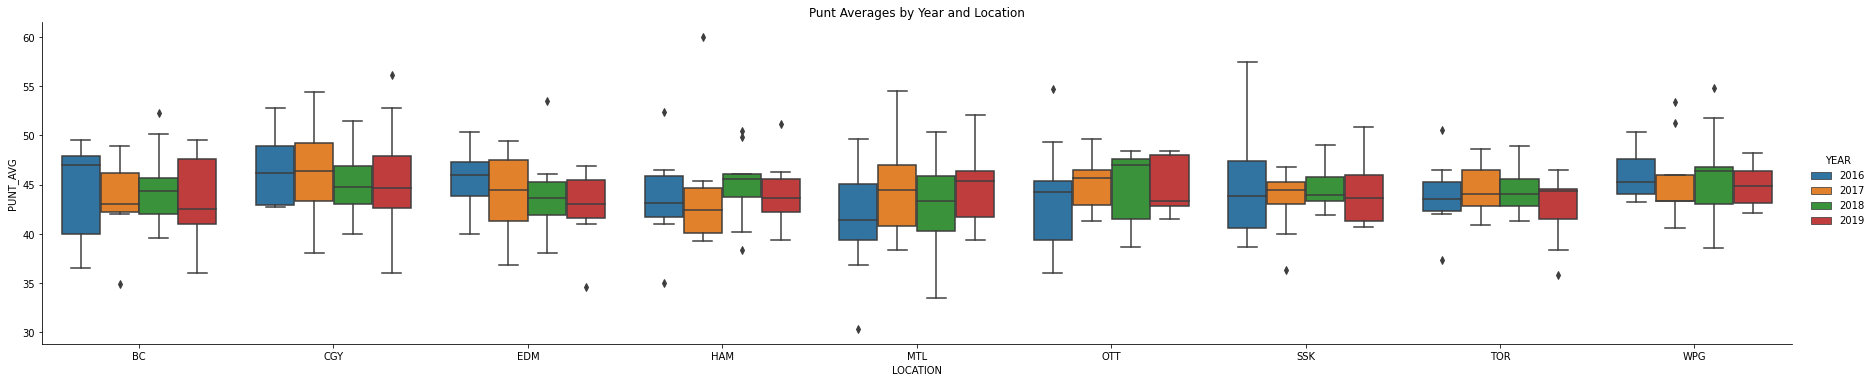

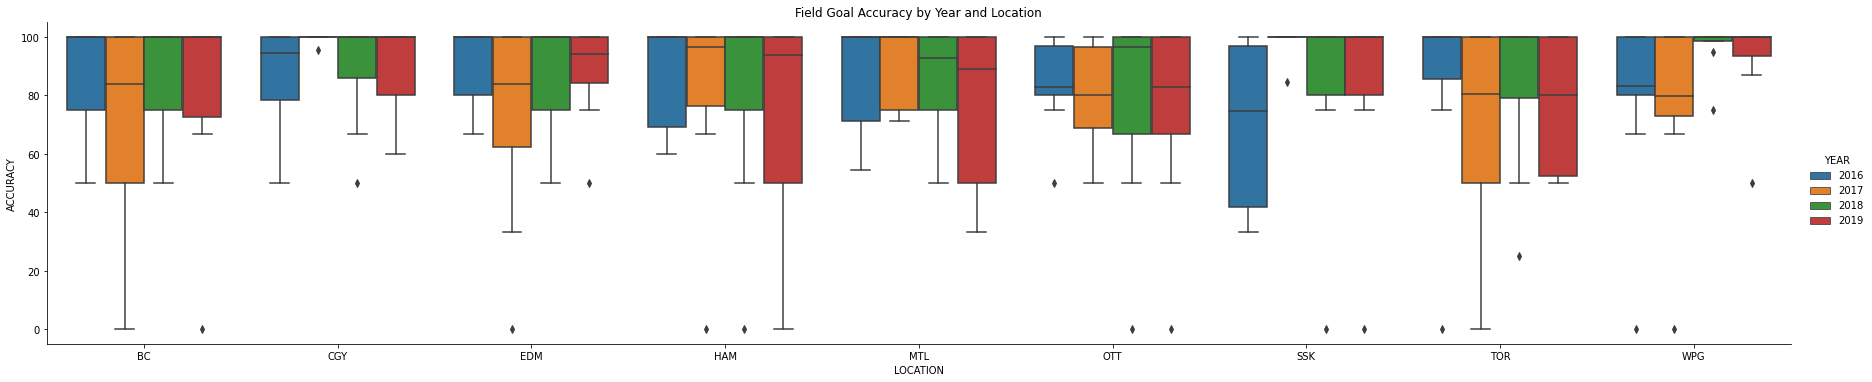

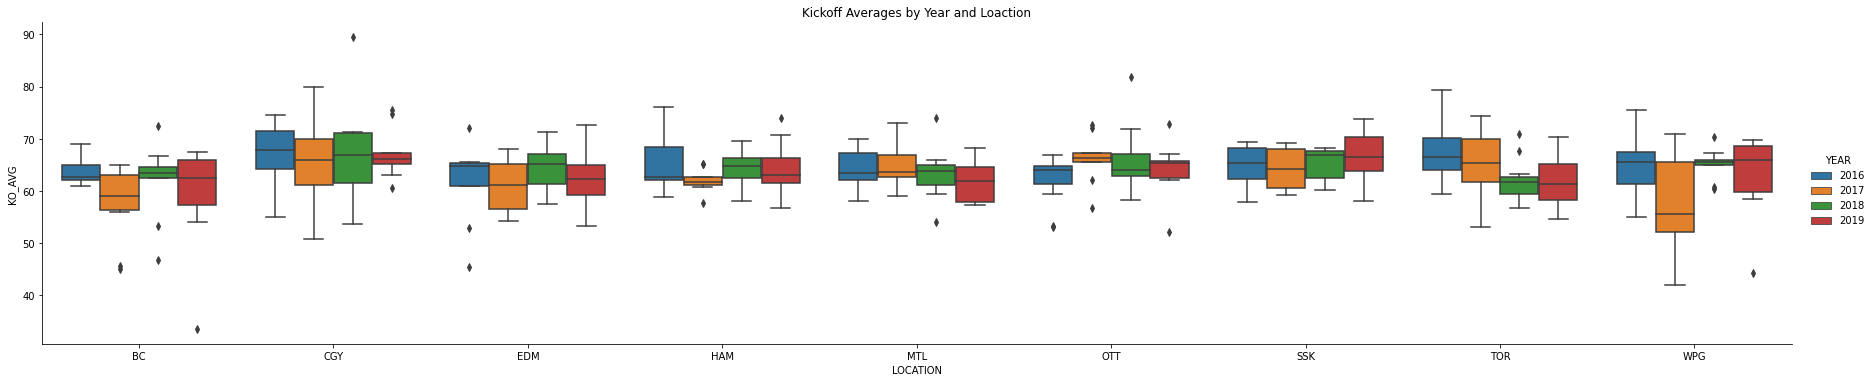

In [64]:
c = sns.catplot(x='LOCATION', y='PUNT_AVG', hue='YEAR', data=df_home_punt_clean, kind='box', aspect=5).set(title='Punt Averages by Year and Location')
d = sns.catplot(x='LOCATION', y='ACCURACY', hue='YEAR', data=df_home_fg_clean, kind='box', aspect=5).set(title='Field Goal Accuracy by Year and Location')
e = sns.catplot(x='LOCATION', y='KO_AVG', hue='YEAR', data=df_home_ko_clean, kind='box', aspect=5).set(title='Kickoff Averages by Year and Loaction')

In [42]:
check1 = df_home_fg_clean[df_home_fg_clean.YEAR.eq(2017) & df_home_fg_clean.LOCATION.eq('SSK')]
check2 = df_home_fg_clean[df_home_fg_clean.YEAR.eq(2017) & df_home_fg_clean.LOCATION.eq('CGY')]

check1['ACCURACY'], check2['ACCURACY']


(29    100.0
 1      84.6
 23    100.0
 27    100.0
 5     100.0
 9     100.0
 28    100.0
 25    100.0
 Name: ACCURACY, dtype: float64,
 27    100.0
 13    100.0
 8     100.0
 11    100.0
 16    100.0
 23    100.0
 3      95.7
 Name: ACCURACY, dtype: float64)

After plotting the data with boxplots showing the different performances in year and location, overall there is no way visually to tell if any particular location has better overall performance than any other. Field goal accuracy in particular is not not well represented with a boxplot as the data has a max of 100 as it is a percentage. You can see however that in Calgary in 2017, Saskatchewan 2017, and Winnipeg 2018 there is no box indicating no variance. Looked more closely at the data and saw that most kickers didn’t miss a single field goal in those locations for that season. The field goal data shows some outliers where accuracy was 0%. Box plots just looking at field goal accuracy don't take into account the amount of kicks so are not a great visual tool for field goals where a game where a kicker went 1 for 1 is scored equal weight to a game where a kicker went 4 for 4.  Overall however not much can be interpreted visually from these plots where each season is separated so going forward the locations seasons will all be combined and aggregated.  
  
  
  
## **Combine Seasons and Plot Data**


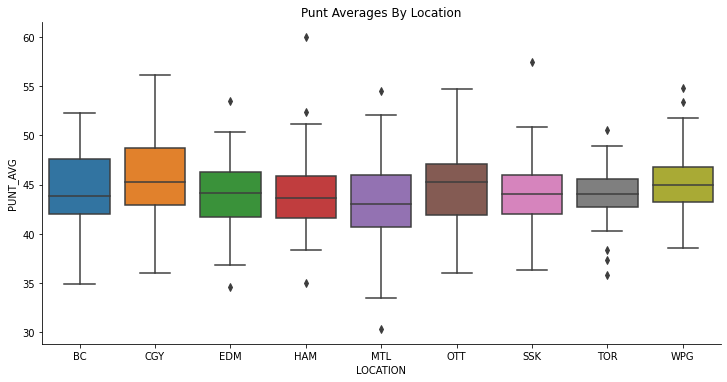

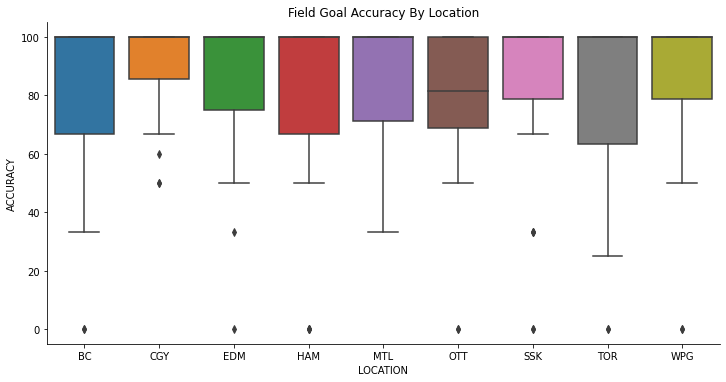

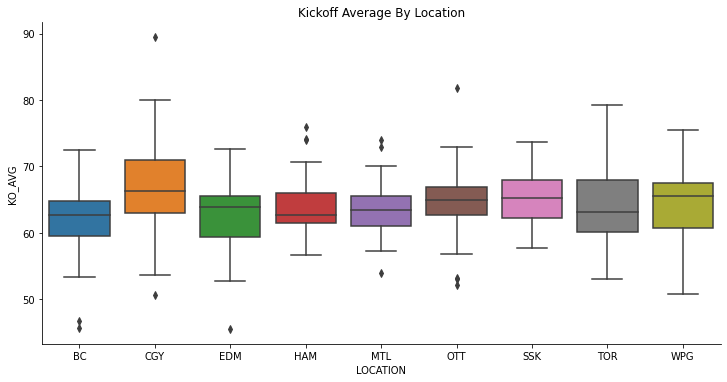

In [43]:
a = sns.catplot(x='LOCATION', y='PUNT_AVG', data=df_home_punt_clean, kind='box', aspect=2).set(title='Punt Averages By Location')
b = sns.catplot(x='LOCATION', y='ACCURACY', data=df_home_fg_clean, kind='box', aspect=2).set(title='Field Goal Accuracy By Location')
c = sns.catplot(x='LOCATION', y='KO_AVG', data=df_home_ko_clean, kind='box', aspect=2).set(title='Kickoff Average By Location')



After combining the seasons together and replotting, the graphs become easier to interpret. Looking at gross punt averages by location, we can see that Calgary and Ottawa appear to have the greatest averages and BC is somewhere in the middle. Field goal accuracy is again hard to interpret as a boxplot but we can see tah Calgary again appears to have the greatest accuracy as it has the smallest box around 100% accuracy. Kickoff average appears pretty even across locations except for Calgary stands out as the highest overall performer in this category. 

## Home Kicker and Punter Weights on Data Analysis

One issue I wanted to address with this  data is that the local team kicker or punter statistics in their home stadiums would have a great weighting on that location’s results. They play at home 9 games a year, so their particular abilities could have the potential of skewing the results towards their individual ability because they will generally have about 9 times more data points then the other kickers in the league that compete at that stadium. During the year each team plays 9 home games so the home kicker has 9 times as much data at that location than most other league kickers. The most a visiting team will play in an opposing stadium is twice a year while most players will only pay in that stadium once. Excluding the home players results from the data and only including the visiting kickers results in the stadium would result in more evenly weighted data. To account for this I created a second dataset that excluded all kicks and punts from the home team kicker in their respective stadiums so that the results could be compared. 




In [23]:
dn = [home_punt_avgs, away_punt_avgs, home_fg_accuracies, away_fg_accuracies, home_ko_avgs, away_ko_avgs]

dn = pd.concat(dn, axis=1)
dn = dn.drop(['LOCATION'], axis=1)
dn.columns = ['PUNT_AVG_ALL', 'PUNT_AVG_AWAY', 'FG_ACCURACY_ALL', 'FG_ACCURACY_AWAY', 'KO_AVG_ALL', 'KO_AVG_AWAY']

dn

,PUNT_AVG_ALL,PUNT_AVG_AWAY,FG_ACCURACY_ALL,FG_ACCURACY_AWAY,KO_AVG_ALL,KO_AVG_AWAY
LOCATION,,,,,,
BC,45.8,44.0,85.1,83.8,61.8,61.8
CGY,45.9,45.8,89.9,89.6,66.7,66.0
EDM,43.9,43.6,86.4,81.9,61.4,62.5
HAM,44.4,43.6,83.1,81.0,63.5,63.9
MTL,44.0,43.9,82.1,84.0,65.7,62.7
OTT,45.6,45.0,83.3,81.2,64.9,65.5
SSK,44.9,44.2,84.9,88.3,64.4,66.0
TOR,44.6,44.1,81.0,80.9,63.3,64.4
WPG,45.0,45.5,87.2,88.1,64.9,62.3


### Plot all performances vs exclusively away games

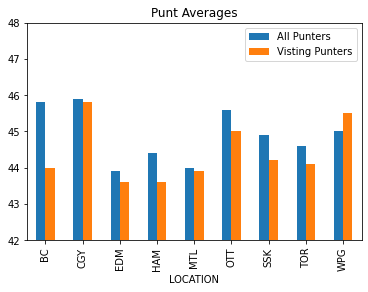

In [44]:
dn_loc = dn.copy()
dn_loc['LOCATION'] = dn.index

ax1 = dn_loc.plot.bar(x='LOCATION', y=['PUNT_AVG_ALL', 'PUNT_AVG_AWAY'], title='Punt Averages')
ax1.set_ylim(42, 48)
ax1.legend(labels=['All Punters', 'Visting Punters'])


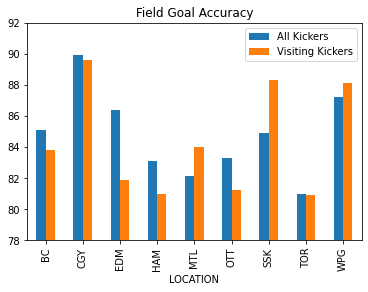

In [27]:
ax2 = dn_loc.plot.bar(x='LOCATION', y=['FG_ACCURACY_ALL', 'FG_ACCURACY_AWAY'], title='Field Goal Accuracy')
ax2.set_ylim(78, 92)
ax2.legend(labels=['All Kickers', 'Visiting Kickers'])

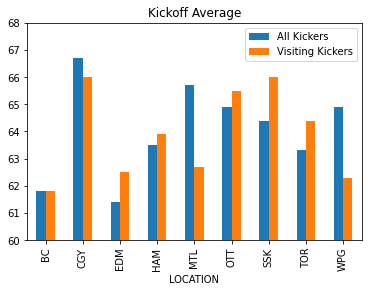

In [30]:

ax3 = dn_loc.plot.bar(x='LOCATION', y=['KO_AVG_ALL',	'KO_AVG_AWAY'], title='Kickoff Average')
ax3.set_ylim(60, 68)
ax3.legend(labels=['All Kickers', 'Visiting Kickers'])

When we compare all games played to only including away games, the most notable difference in punting average is actually in BC where the home punters results have significantly affected the average upwards from 44.0 to 45.8 yards. Field goal accuracy shows a slight drop in accuarcy in BC when removing the home kickers performance. The most notable diffences are in Edmonton (EDM) where the home kickers boost the accuarcy from 81.9% to 86.4% but in Saskatchewan (SSK) the home kickers performances drops the accuarcy from 88.3% to 84.9%. This shows that including the home players performance in the results can have a large impact on the overall results so it makes sense to exclude them going forward or at least keep them seperate. Otherwise we may be interpreting results that are actually just the result of a particularly strong or weak home town player's performaces over a few seasons as opposed to the affect of the location itself. When analyzing the kickoff average results, we can see in Montreal and Winnipeg the home kicker drastically brings up the average at those stadiums. The rest of the stadiums are more similar in their performances but there are still significant differences, whether positive or negative, after removing the home team kicker from the data. 

# Remove Home Kickers results from Data


In [527]:
# drop the columns that include the home players in the data
dn_away_only = dn.drop(['PUNT_AVG_ALL', 'FG_ACCURACY_ALL', 'KO_AVG_ALL'], axis=1)
dn_away_only

,PUNT_AVG_AWAY,FG_ACCURACY_AWAY,KO_AVG_AWAY
LOCATION,,,
BC,44.0,83.8,61.8
CGY,45.8,89.6,66.0
EDM,43.6,81.9,62.5
HAM,43.6,81.0,63.9
MTL,43.9,84.0,62.7
OTT,45.0,81.2,65.5
SSK,44.2,88.3,66.0
TOR,44.1,80.9,64.4
WPG,45.5,88.1,62.3


## Scale the Data and Visualize
By scaling the data, this will make comparison across all three kicking types easier to interpret.  Scaling transforms the data so that the newly scaled data will all be within the same range, in this case 0-1. 
The min-max scaler takes each data sets min and max values and converts those to the range of 0-1. Looking at the results where punt distance, field goal accuracy, and kickoff distance are all scaled it becomes obvious that Calgary has the max for all three categories and Saskatchewan ties Calgary in kickoff distance. Edmonton and Hamilton are the worst locations for punt, Toronto for field goal accuracy and BC for kickoff distance. By stacking the results we can see overall how each location stacks up with all three categories considered. In this case again Calgary leads in performance which is no surprise after seeing they were the top in each category individually as well. Next best was Saskatchewan with very strong field goal and kickoff performance carrying the load. From this plot we see that there are three bottom performers in BC, Edmonton, and Hamilton with Edmonton appearing to be the worst overall. 

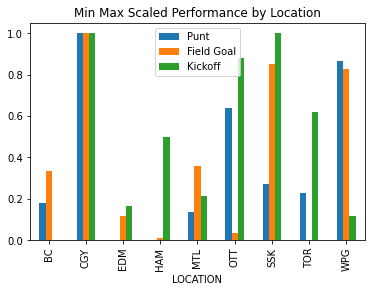

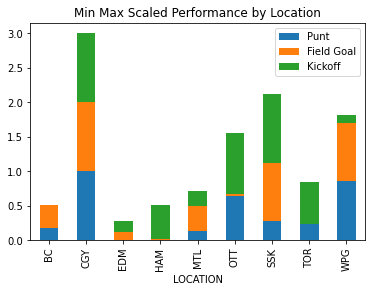

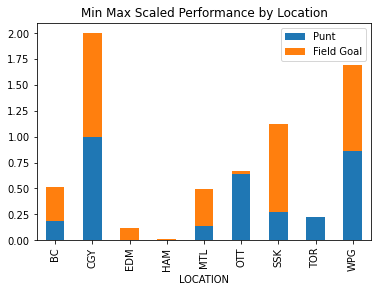

In [529]:
## Minmax Scaler

scaler = preprocessing.MinMaxScaler()
dn_scaled = pd.DataFrame(scaler.fit_transform(dn_away_only), columns=dn_away_only.columns)
# add location back 
dn_scaled['LOCATION'] = dn.index
ax3 = dn_scaled.plot.bar(x='LOCATION', title='Min Max Scaled Performance by Location')
ax3.legend(labels=['Punt', 'Field Goal', 'Kickoff'])
ax4 = dn_scaled.plot.bar(x='LOCATION', title='Min Max Scaled Performance by Location', stacked=True, sort_columns=True)
ax4.legend(labels=['Punt', 'Field Goal', 'Kickoff'])
ax5 = dn_scaled.plot.bar(x='LOCATION', y=['PUNT_AVG_AWAY','FG_ACCURACY_AWAY'], title='Min Max Scaled Performance by Location', stacked=True, sort_columns=True)
ax5.legend(labels=['Punt', 'Field Goal'])


Using sklearn's standard scaler helps to visualize which locations were above and below average in each discipline and by how much. The standard scaler "standarizes features by removing the mean and scaling to unit variance". We can now look at the plot and see that while Calgary was top in all three categories, punting held the greatest advantage over the rest of the stadiums. It's noticable how poorly kickoff performance in BC was.  BC Edmonton and Montreal were the only three stadiums to be below average in all three disciplines while calgary was the only stadium to be above average in all three. Only three stadiums were above the mean in field goal performance, Calgary, Saskatchewan nad Winnipeg and they were all quite significantly above the average. Again only three stadiums, Calgary, Ottawa and Winnipeg, were above average in punting with the rest below. From these plots the front runners for best stadiums to play in for kicking performance would be Calgary, Saskatchewan, Winnipeg and Ottawa. The hardest stadiums to perform in look to be Edmonton, BC, Hamilton and Toronto and then Montreal. Kickoffs have somewhat less importance than the other two disciplines so I wanted to look as well at the best stadiums of those two. Looking specificaly at punting and field goal accuracy, Calgary, Winnipeg and then Saskatchewan are top while Toronto, Edmonton, and Hamilton are last. Hamilton is tied for last in punt and 2nd last in field goal accuarcy. Edmonton and Toronto are the next worst when combining punt and field goal performances. 

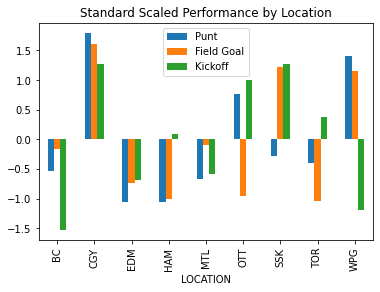

In [73]:
# Standard Scaler
standard_scaler = preprocessing.StandardScaler()
dn_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(dn_away_only), columns=dn_away_only.columns)
dn_standard_scaled['LOCATION'] = dn_away_only.index
ax5 = dn_standard_scaled.plot.bar(x='LOCATION', title='Standard Scaled Performance by Location')
ax5.legend(labels=['Punt', 'Field Goal', 'Kickoff'])

## Compare Outdoor vs Indoor (BC) Data

Now I will compare BC to all the other outdoor stadiums. In order to compare the indoor vs outdoor data, a column of the combined performances of all outdoor locations (not BC) will be added to the dataset. This will requiring aggregating all the data from the other locations, mainly field goal attempts and attempts made, then punt yards and number of punts. The location will be labeled as 'OUT' for outdoors.

In [63]:
def add_outdoor_column(df):
   df['IN_OUT'] = np.where(df['LOCATION'] == 'BC', 'IN','OUT')
   return df

df_away_punt_inout = add_outdoor_column(df_away_punt_clean)
df_away_fg_inout = add_outdoor_column(df_away_fg_clean)
df_away_ko_inout = add_outdoor_column(df_away_ko_clean)



## Visualizations of Indoors (BC) vs Outdoors

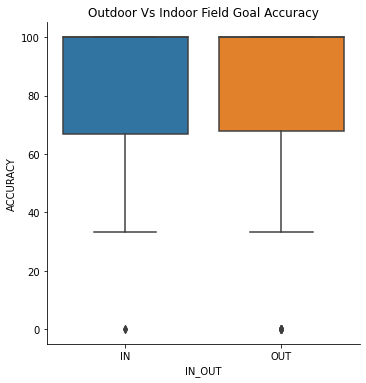

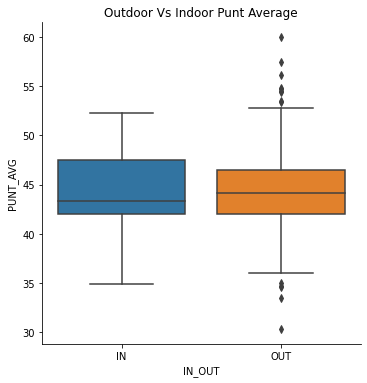

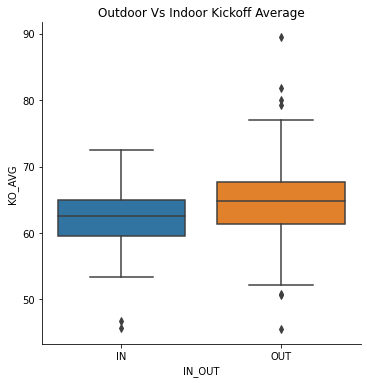

In [66]:
p = sns.catplot(
      x='IN_OUT', 
      y='ACCURACY', 
      data=df_away_fg_inout, 
      kind='box'
   ).set(title='Outdoor Vs Indoor Field Goal Accuracy')

o = sns.catplot(
      x='IN_OUT',
      y='PUNT_AVG',
      data=df_away_punt_inout,
      kind='box'
   ).set(title='Outdoor Vs Indoor Punt Average')

q = sns.catplot(
      x='IN_OUT',
      y='KO_AVG',
      data=df_away_ko_inout,
      kind='box'
   ).set(title='Outdoor Vs Indoor Kickoff Average')

## Get Outdoor Overall Punt Average, Kickoff Average and Field Goal Accuracy

Use previously defined function to get aggregate averages and accuracies but this time have the aggregates grouped on the newly created `IN_OUT` column.

In [92]:
df_away_punt_inout_agg = get_location_punt_averages(df_away_punt_inout, 'IN_OUT')
df_away_fg_inout_agg = get_location_fg_accuracies(df_away_fg_inout, 'IN_OUT')
df_away_ko_inout_agg = get_location_ko_averages(df_away_ko_inout, 'IN_OUT')


df_in_out_agg = pd.concat([df_away_fg_inout_agg, df_away_punt_inout_agg, df_away_ko_inout_agg], axis=1)
df_in_out_agg = df_in_out_agg.loc[:,~df_in_out_agg.columns.duplicated()]

df_in_out_agg


,ACCURACY,IN_OUT,PUNT_AVG,KO_AVG
IN_OUT,,,,
IN,83.8,IN,44.0,61.8
OUT,84.1,OUT,44.5,64.1


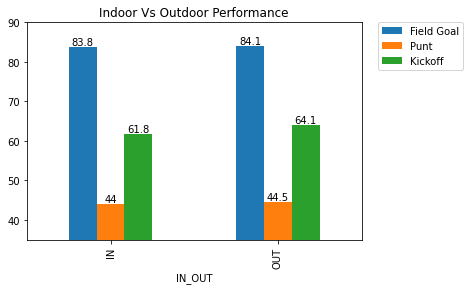

In [105]:
ax12 = df_in_out_agg.plot.bar(
      title='Indoor Vs Outdoor Performance',
      x='IN_OUT', 
      y=['ACCURACY','PUNT_AVG','KO_AVG']
   )
ax12.set_ylim(35, 90)
ax12.legend(
      bbox_to_anchor=(1.05, 1),
      loc='upper left',
      borderaxespad=0.,
      labels=['Field Goal','Punt','Kickoff']
   )
for container in ax12.containers:
   ax12.bar_label(container)

When we aggregate all the outdoor stadiums data to compare to the indoor stadium in BC we find that the punting average for away only games is actually below outdoor stadiums. Punters averaged 44.0 yards per punt in BC while outdoors the average was 44.5 yards so players performanced better overall outdoors than indoors in BC but these are rather close. When looking at the aggregate of field goal accuracy, they are extremely close. Overall field goal accuracy was very similar in BC place compared to outdoor stadiums. Over the 4 seasons visiting kickers accuarcy was 83.8% while visiting kicker's accuracy in outdoor stadiums totalled 84.1%. While both field goal accuracy and punt average are very close indoors vs outdoors, kickoff average is quite a bit different with indoors being 61.8 yards and outdoors 64.1 yards per kickoff. A difference of 2.3 yards in favour of kicking outdoors vs indoors. 

## **Preliminary Summary and Analysis**

Looking at the away performance data, punting performances were the best overall in Calgary, Ottawa (OTT), and Winnipeg (WPG) while the worst punting was in Edmonton, Hamilton (HAM), and Montreal (MTL).  The best field goal performances were in Calgary (CGY), Saskatchewan (SSK), and Winnipeg (WPG) while the worst were in Toronto (TOR), Hamilton (HAM), and Ottawa (OTT). It would appear that Edmonton (EDM), Hamilton (HAM), Montreal (MTL), and Toronto (TOR) have the worst performance outcomes overall. Hamilton, Montreal, and Toronto are all in the Eastern division and possibly more importantly, the Eastern time zone. Studies have shown that travel from West to “East has a greater detrimental effect on sleep, subjective jet lag, fatigue, and motivation” (https://pubmed.ncbi.nlm.nih.gov/28719491/). This could be a possible reason for the subpar performances in this grouping of stadiums. BC was the worst in kickoff average while Calgary was the best. 

Looking at the consistent top performance across both field goals and punting in Calgary, it could possibly be a result of the higher elevation of the city. The higher the elevation, the lower the air density and the lower the air density, the less air molecules there are in the path of the ball to slow it down. "A punted or kicked football will run headlong into a steady barrage of air molecules. Their combined drag will slow it down, sometimes dramatically. But remember, in low density air, molecules are fewer and farther between" (https://entertainment.howstuffworks.com/physics-and-football-denvers-altitude-affect-field-goals.htm). Calgary’s elevation is 1045m above sea level while the next highest city, Edmonton, is only 645m. BC is located at sea level so this could be a key as well as to why performances don’t increase as much as one would expect being indoors. Toronto, Montreal and Hamilton all have very low elevations as well and had below average performances. However, Ottawa is also a lower elevation city and while it had below average field goal accuracy, it had well above average punting performances.

Another reason why BC may not have the punting performance results as anticipated is how punt distance is measured. Punt yardage is calculated by where the ball is actually picked up, not where it initially lands. In games with tough conditions, these conditions can also be tough for the returner who’s job is to catch the ball. If the returner is unable to catch the ball in the air due to a wild punt in a high wind game, there is a chance the ball can bounce past the returner. The punt is then recorded as a longer distance even though the punter may have not actually hit the ball very well. This poses an interesting idea that it may turn out that while indoor stadiums are favourable to the punter for consistent contact and accuracy, this may also play in favour of the returner for overall easier to catch punts. It would be interesting to see if there was more consistency, or less variance, overall in punting average in BC compared to the other stadiums.

## Individual Performance Comparisons


In [127]:
df_away_punt_clean.head()

,YEAR,NAME,LOCATION,TEAM,NUMBER_OF_PUNTS,PUNT_YDS,PUNT_AVG,IN_OUT
11,2016,"BARTEL, Josh",BC,SSK,7,335,47.9,IN
13,2017,"BARTEL, Josh",BC,SSK,7,316,45.1,IN
12,2018,"BARTEL, Josh",BC,SSK,8,317,39.6,IN
26,2017,"BEDE, Boris",BC,MTL,5,210,42.0,IN
5,2018,"BEDE, Boris",BC,MTL,9,378,42.0,IN


In [236]:

df_ind_punt_pivot = pd.pivot_table(df_away_punt_clean, values=['NUMBER_OF_PUNTS', 'PUNT_YDS'], index=['NAME'], columns=['LOCATION'], fill_value=0, aggfunc=np.sum)
df_ind_punt_pivot

#FILTER OUT PUNTERS WITH LESS THAN 20 TOTAL PUNTS
df_ind_punt_pivot['TOTAL_PUNTS'] = df_ind_punt_pivot.loc[:, ['NUMBER_OF_PUNTS']].iloc[:, :].sum(axis=1)
df_ind_punt_filtered = df_ind_punt_pivot[df_ind_punt_pivot.TOTAL_PUNTS.gt(25)]

df_ind_punt_filtered.head()


NUMBER_OF_PUNTS                                 PUNT_YDS  \
LOCATION                       BC CGY EDM HAM MTL OTT SSK TOR WPG       BC   
NAME                                                                         
BARTEL, Josh                   22  26  37  24  24  24   3  17  38      968   
BEDE, Boris                    20  30  16  22   0  26  23  33  23      842   
CASTILLO, Sergio                6  23   7   0   0   7   4  15   0      257   
HAJRULLAHU, Lirim              23  27  20  15  21  38  27  14  21     1018   
LEONE, Richie                  16  20  19  26  19   7  32  30  21      795   

                                                                  TOTAL_PUNTS  
LOCATION            CGY   EDM   HAM   MTL   OTT   SSK   TOR   WPG              
NAME                                                                           
BARTEL, Josh       1113  1606   990  1008  1044   122   759  1573         215  
BEDE, Boris        1320   747   927     0  1194   990  1503  1034         193  
CASTILLO, Sergio   1075   317     0     0   294   181   656     0          62  
HAJRULLAHU, Lirim  1243   854   628   845  1698  1189   621   930         206  
LEONE, Richie      1069   854  1204   899   383  1516  1381   995         190

In [274]:

df_ind_fg = pd.pivot_table(df_away_fg_clean, values=['FG_MADE','FG_ATTEMPTS'], index=['NAME'], columns=['LOCATION'], fill_value=0, aggfunc=np.sum)
df_ind_fg['TOTAL_ATTEMPTS'] = df_ind_fg.loc[:, ['FG_ATTEMPTS']].iloc[:, :].sum(axis=1)

# FILTER OUT ANY KICKERS WITH LESS THAN 15 ATTEMPTS
df_ind_fg_filtered = df_ind_fg[df_ind_fg.TOTAL_ATTEMPTS.gt(15)]
df_ind_fg_filtered_2 = df_ind_fg[df_ind_fg.TOTAL_ATTEMPTS.gt(40)]
df_ind_fg_filtered


FG_ATTEMPTS                                 FG_MADE          \
LOCATION                   BC CGY EDM HAM MTL OTT SSK TOR WPG      BC CGY EDM   
NAME                                                                            
BEDE, Boris                 5   5   7   3   0  12  11   8  10       3   5   6   
CASTILLO, Sergio            5   1  11   0   3   8   6   4   7       3   1   9   
CRAPIGNA, Tyler             3   4   6   8   8  10   0   6   1       1   4   5   
HAJRULLAHU, Lirim          19   9   9   9  15  17  14   7  10      15   7   6   
LAUTHER, Brett              8   8   3   6   2   3   0   6   7       7   7   3   
LEONE, Richie               0   2   3   5   7   2   3   3   5       0   1   2   
LONG, Ty                    0   9   6   3   5   4   1   6   7       0   9   4   
MAHER, Brett                6   5   4   6  12   5   5   8   2       6   5   4   
MEDLOCK, Justin            11  10  16  18  16  19  23  11   0       9  10  12   
MILO, Christopher           4   5   4   3   9   0   6   4   0       4   5   4   
PAREDES, Rene              19   0  11  12  11  18  14  12  11      17   0  10   
WARD, Lewis                 3   5   5  12   5   0   5   6   2       3   5   5   
WHYTE, Sean                12   8   0   7  10   7  12  10  17      12   6   0   

                                          TOTAL_ATTEMPTS  
LOCATION          HAM MTL OTT SSK TOR WPG                 
NAME                                                      
BEDE, Boris         3   0  10  10   3   9             61  
CASTILLO, Sergio    0   3   8   6   3   6             45  
CRAPIGNA, Tyler     8   5   8   0   6   1             46  
HAJRULLAHU, Lirim   7  15  14  13   7   9            109  
LAUTHER, Brett      4   2   3   0   5   7             43  
LEONE, Richie       3   5   1   1   3   4             30  
LONG, Ty            3   4   2   0   6   7             41  
MAHER, Brett        6  10   4   3   6   1             53  
MEDLOCK, Justin    13  15  16  21   9   0            124  
MILO, Christopher   3   6   0   4   3   0             35  
PAREDES, Rene       9   9  14  14  11   9            108  
WARD, Lewis        12   5   0   5   4   2             43  
WHYTE, Sean         7   8   5  11   9  15             83

In [275]:
# df_ind_fg_acc = 
df_ind_fg_acc = (df_ind_fg_filtered.FG_MADE / df_ind_fg_filtered.FG_ATTEMPTS * 100).round(1)
df_ind_fg_acc_2 = (df_ind_fg_filtered_2.FG_MADE / df_ind_fg_filtered_2.FG_ATTEMPTS * 100).round(1)
df_ind_fg_acc




LOCATION,BC,CGY,EDM,HAM,MTL,OTT,SSK,TOR,WPG
NAME,,,,,,,,,
"BEDE, Boris",60.0,100.0,85.7,100.0,NaN,83.3,90.9,37.5,90.0
"CASTILLO, Sergio",60.0,100.0,81.8,NaN,100.0,100.0,100.0,75.0,85.7
"CRAPIGNA, Tyler",33.3,100.0,83.3,100.0,62.5,80.0,NaN,100.0,100.0
"HAJRULLAHU, Lirim",78.9,77.8,66.7,77.8,100.0,82.4,92.9,100.0,90.0
"LAUTHER, Brett",87.5,87.5,100.0,66.7,100.0,100.0,NaN,83.3,100.0
"LEONE, Richie",NaN,50.0,66.7,60.0,71.4,50.0,33.3,100.0,80.0
"LONG, Ty",NaN,100.0,66.7,100.0,80.0,50.0,0.0,100.0,100.0
"MAHER, Brett",100.0,100.0,100.0,100.0,83.3,80.0,60.0,75.0,50.0
"MEDLOCK, Justin",81.8,100.0,75.0,72.2,93.8,84.2,91.3,81.8,NaN


In [226]:
df_ind_punt_avg = (df_ind_punt_filtered.PUNT_YDS / df_ind_punt_filtered.NUMBER_OF_PUNTS).round(1)
df_ind_punt_avg

LOCATION,BC,CGY,EDM,HAM,MTL,OTT,SSK,TOR,WPG
NAME,,,,,,,,,
"BARTEL, Josh",44.0,42.8,43.4,41.2,42.0,43.5,40.7,44.6,41.4
"BEDE, Boris",42.1,44.0,46.7,42.1,NaN,45.9,43.0,45.5,45.0
"CASTILLO, Sergio",42.8,46.7,45.3,NaN,NaN,42.0,45.2,43.7,NaN
"HAJRULLAHU, Lirim",44.3,46.0,42.7,41.9,40.2,44.7,44.0,44.4,44.3
"LEONE, Richie",49.7,53.4,44.9,46.3,47.3,54.7,47.4,46.0,47.4
"LONG, Ty",NaN,49.9,46.2,45.1,50.3,47.3,44.9,42.1,49.0
"MAHER, Brett",40.5,41.0,48.5,44.2,48.5,44.3,44.5,44.8,51.5
"MAVER, Rob",42.7,NaN,43.9,45.2,44.4,43.5,42.8,41.7,46.1
"MEDEIROS, Zackary",42.5,39.8,41.0,43.1,43.3,41.5,45.9,37.3,42.1


In order to compare each kicker to their own performances across stadiums I aggregated each kickers results across all seasons to have enough data for each kicker and punter. Earlier we found through visual analysis that comparing results across each season was not a useful tool to see what was going on and this limits the amount of data available for each location if it is split up by season as well. For punters and kickers I got the total amount of punts or field goals each had and decided to remove those that fell below a certain amount. I determined this by looking at the data and using an amount that would keep the most kickers in that had data across the majority of stadiums, removing those that had only a few kicks or punts in some stadiums and none in many others. There are kickers and punters who may have only played a handful of games and therfore didn't have data across all stadiums so this way we can limit the results to kickers and punters with data in all the stadiums. However this is away data only so there are data points that are NaN (not a number) as that kicker would have data in those stadiums but this is excluded as that was their home stadium. It is not 0% accuracy or 0 yard average so it is recorded as NaN so it is not included in any column statistics. For example in the punt dataframe BEDE played all 4 seasons in Montreal so under his column for Montreal it is NaN.

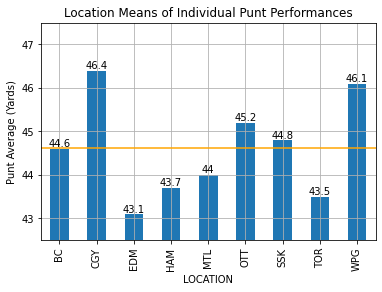

In [234]:

ax15 = df_ind_punt_avg.mean().round(1).plot(
   kind='bar', 
   ylim=(42.5, 47.5), 
   grid=True, 
   title='Location Means of Individual Punt Performances', 
   ylabel='Punt Average (Yards)'
)
ax15.axhline(df_ind_punt_avg.mean().mean(), color='orange')
for container in ax15.containers:
   ax15.bar_label(container)



From this graph we can see that Calgary and Winnipeg are clear leaders in punt average with above 46 yards averaged. Edmonton is the clear bottom with 43.1 yards per punt followed by Toronto, Hamilton and Montreal. Looing at BC, the lone indoor location, we see that individuals performances were right around the mean of all the stadiums. 

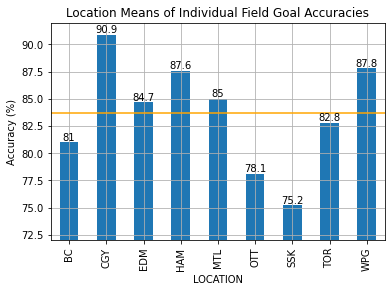

In [235]:
ax16 = df_ind_fg_acc.mean().round(1).plot(
   kind='bar',
   ylim=(72,92),
   grid=True,
   title='Location Means of Individual Field Goal Accuracies',
   ylabel='Accuracy (%)'
)
ax16.axhline(df_ind_fg_acc.mean().mean(), color='orange')
for container in ax16.containers:
   ax16.bar_label(container)


From this graph we see that Calgary is the clear leader in field goal accuracy being above 90%, with Winnipeg and Hamilton sharing second place around 87.5% accuracy. Saskatchewan was the worst place for field goal accuracy with  followed by Ottawa. BC is actually the 3rd worst stadium in regards to field goal performance. 

<AxesSubplot:title={'center':'Aggregate Punt Average vs Individual Mean'}, xlabel='LOCATION'>

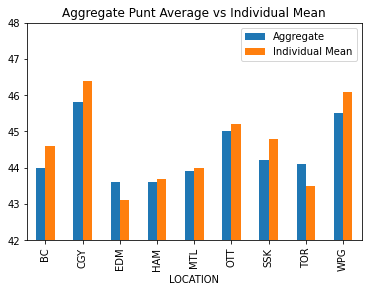

In [266]:
df_punt_compare = pd.concat([dn_away_only['PUNT_AVG_AWAY'], df_ind_punt_avg.mean()], axis=1).round(1)
df_punt_compare.columns = ['Aggregate', 'Individual Mean']
df_punt_compare.plot(kind='bar', ylim=(42, 48), title='Aggregate Punt Average vs Individual Mean')


<AxesSubplot:title={'center':'Aggregate Field Goal Accuracy vs Individual Mean'}, xlabel='LOCATION'>

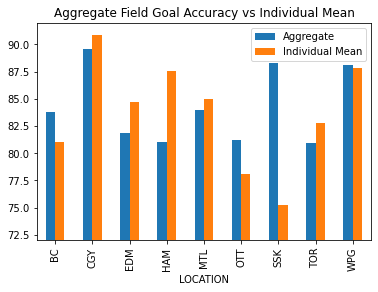

In [268]:
df_fg_compare = pd.concat([dn_away_only['FG_ACCURACY_AWAY'], df_ind_fg_acc.mean()], axis=1).round(1)
df_fg_compare.columns = ['Aggregate', 'Individual Mean']
df_fg_compare.plot(kind='bar', ylim=(72, 92), title='Aggregate Field Goal Accuracy vs Individual Mean')

By comparing the previously found metrics that was the aggregate of overall punts and overall field goals at each location with the mean of individual performances, we can see some differences in the results. The biggest difference is in Saskatchewan's field goal accuracy, it drops from one of the top performing stadiums to one of the worst when the data is broken up into indivdual performances. Looking closely at the data in this particular case I found there are three extremely poor individual performances that drop the overall average. Each of these data points the kickers are on the lower threshold of total attempts so I will bump up the amount of attempts required. One kicker went 0 for 1 in this stadium putting a 0% into the count which has a large effect on the mean. After increasing the minimum required field goal attempts, we can still in the graph belowthat  Saskatchewan has a fairly significant drop in accuracy but not as severe as before with the outliers included. Hamilton and Edmonton see a boost to accuracy while BC sees a slight drop and otherwise data stays similar.  

Looking at the punt data overall it is fairly similar with slight changes. Calgary and Winnipeg actually increase their lead in performance while Edmonton drops further into last place. BC increases slightly along with Saskatchewan while Toronto also drops.


<AxesSubplot:title={'center':'Aggregate Field Goal Accuracy vs Individual Mean (Increased Attempts Threshold)'}, xlabel='LOCATION'>

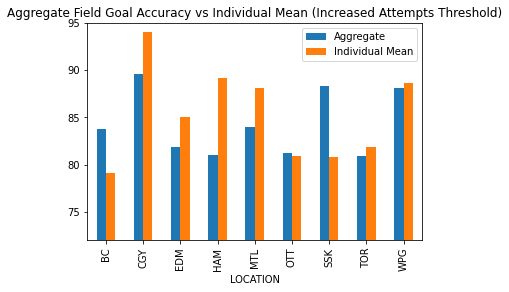

In [531]:
df_fg_compare_2 = pd.concat([dn_away_only['FG_ACCURACY_AWAY'], df_ind_fg_acc_2.mean()], axis=1).round(1)
df_fg_compare_2.columns = ['Aggregate', 'Individual Mean']
df_fg_compare_2.plot(kind='bar', ylim=(72, 95), title='Aggregate Field Goal Accuracy vs Individual Mean (Increased Attempts Threshold)')

# DETAILED KICKING DATA
Use data that contains individual field goal results. 
Data is for each field goal kicked, includes location, team, distance, whethere it was missed or made.  
This improves upon the CFL data as the CFL data does not contain detailed information for kicks that were missed.
This way we can look more closely at mid range to long range field goals where elements will be more of a factor than just mental errors. If a particular stadium has a higher percentage of shorter kicks for whatever reason, this could skew the results to it being a better stadium field goal performance wise when in actuality it is just because there has been a higher proportion of shorter, high percentage field goals. 

## Import Excel Spreadsheet Data
This includes data obtained from a reporter in the CFL who has taken data from the CFL stats and aggregated it himself into an excel spreadsheet  
This data has greater detail for fieldgoals - individual fgs, distance, made or missed  
Punt data contains net punt so the result of change in field position from the punt
- talk about all the factors that go into this so not an isolated punt but worth looking at
- more of a team statistic


In [559]:
fg_data_df = pd.read_excel('fg_data.xlsx', engine='openpyxl')

In [18]:
fg_data_df.head()

,Regular/Playoffs,Stadium,Indoor/Outdoor,Home,TEAM,Year,Game,Kicker,Distance,Made,Miss,Single,H/A,Play by play text
0,R,tor,O,TOR,HAM,2016,10,Maher,39,Y,NaN,NaN,A,"(04:41) B. MAHER Field Goal (39 yds), Good"
1,R,tor,O,TOR,HAM,2016,10,Maher,38,Y,NaN,NaN,A,"(12:10) B. MAHER Field Goal (38 yds), Good"
2,R,tor,O,TOR,HAM,2016,10,Maher,50,Y,NaN,NaN,A,"(08:58) B. MAHER Field Goal (50 yds), Good"
3,R,tor,O,TOR,TOR,2016,10,Hajrullahu,40,Y,NaN,NaN,H,"(03:37) L. HAJRULLAHU Field Goal (40 yds), Good"
4,R,tor,O,TOR,TOR,2016,10,Hajrullahu,51,Y,NaN,NaN,H,"(00:04) L. HAJRULLAHU Field Goal (51 yds), Good"


In [278]:
punt_data_df.head()

,I/O,TEAM,HOME,YEAR,PUNTER,LOS,POST-PUNT,SINGLE,NET,EV OF PUNT,PLAY-BY-PLAY
0,O,TOR,TOR,2016,L.Hajrullahu,37,41,NaN,32,-1.759234,NaN
1,O,TOR,TOR,2016,L.Hajrullahu,48,19,NaN,43,-1.548484,NaN
2,O,TOR,TOR,2016,L.Hajrullahu,45,33,NaN,32,-1.543891,NaN
3,O,TOR,TOR,2016,L.Hajrullahu,64,6,NaN,40,-1.588132,NaN
4,O,TOR,TOR,2016,L.Hajrullahu,27,53,NaN,30,-2.329292,NaN


In [279]:
def clean_detailed_fg(df):
   # drop columns not interested in
   df = df.drop(['Regular/Playoffs', 'Game', 'Play by play text', 'Single'], axis=1)
   df = df.rename(columns={'Stadium':'LOCATION', 'Year':'YEAR', 'Distance':'DISTANCE', 'Kicker':'NAME', 'Indoor/Outdoor': 'IN_OUT', 'Home':'HOME', 'Made':'MADE', 'Miss':'MISS', 'H/A':'HOMEAWAY'})
   # fill in nan values with 0 for Made col
   df['MADE'] = df['MADE'].fillna(0)
   df['MISS'] = df['MISS'].fillna(0)
   # replace Y and y in Made col with 1 to make it a binary column
   df = df.replace({'MADE': {'Y': 1, 'y': 1}})
   return df

def clean_detailed_punt(df):
   df = df.drop(['PLAY-BY-PLAY'], axis=1)
   df = df.rename(columns={'HOME':'LOCATION'})
   df['SINGLE'] = df['SINGLE'].fillna(0)
   return df

fg_data_df_clean = clean_detailed_fg(fg_data_df)
punt_data_df_clean = clean_detailed_punt(punt_data_df)


# Field Goal Analysis
Determine at what range field goal accuracy begins to decline significantly. Then will use this range to compare across stadiums.
Get the overal accuracy at different distances for field goals and plot results.



Text(0.5, 1.0, 'Field Goal Accuarcy by Distance')

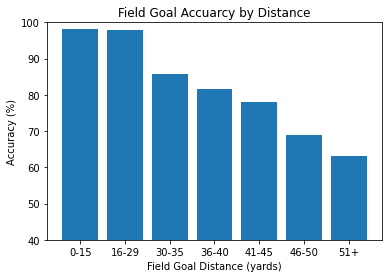

In [280]:
def get_accuracy(df):
   made_fgs = (df['MADE'] == 1).sum()
   missed_fgs = (df['MADE'] == 0).sum()
   accuracy = (made_fgs / (made_fgs + missed_fgs)).round(3)*100
   return accuracy

def get_distance_accuracies(df):
   df015_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 0) & (df['DISTANCE'] <= 15)]) 
   df1629_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 16) & (df['DISTANCE'] <= 29)])
   df3035_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 30) & (df['DISTANCE'] <= 35)])
   df3640_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 36) & (df['DISTANCE'] <= 40)])
   df4145_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 41) & (df['DISTANCE'] <= 45)])
   df4650_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 46) & (df['DISTANCE'] <= 50)])
   df51_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 51)])
   accuracies = [df015_acc,df1629_acc, df3035_acc,df3640_acc, df4145_acc, df4650_acc, df51_acc]
   return(accuracies)

fg_dist_accs = get_distance_accuracies(fg_data_df_clean)

plt.bar(['0-15', '16-29', '30-35', '36-40', '41-45', '46-50','51+'],fg_dist_accs)
plt.ylim(40,100)
plt.xlabel('Field Goal Distance (yards)')
plt.ylabel('Accuracy (%)')
plt.title('Field Goal Accuarcy by Distance')

### See that Accuracies are near 100% up until the 30 yard range when there is a large drop off to about 85%.  
### So for our FG data going forward we will use only field geals kicked from 30 yards and beyond to eliminate kicks that have little chance of missing.
### This is so that if one stadium happens to have a higher % of shorter distance fgs this will not skew the data to it being a more accurate stadium.

In [281]:
def remove_short_fgs(dist, df):
   new_df = df.loc[df['DISTANCE'] > dist]
   return new_df

long_fg_data = remove_short_fgs(29, fg_data_df_clean)

print('ALL FG MAKES AND MISSES DATA COUNT: \n', fg_data_df_clean['MADE'].value_counts())
print('LONG FG MAKES AND MISSES DATA COUNT: \n', long_fg_data['MADE'].value_counts())

ALL FG MAKES AND MISSES DATA COUNT: 
 1    1594
0     286
Name: MADE, dtype: int64
LONG FG MAKES AND MISSES DATA COUNT: 
 1    939
0    272
Name: MADE, dtype: int64


By eliminating short fieldgoals with a high rate of accuracy, those field goals from 29 yards and in, we have removed 655 made fieldgoals but only 14 misses which is an accuracy rate of 97.9%.   
Field goal accuracy from 30 and beyond is 78%.   
Now we will break up the data into locations and look at accuracy in each location from 30 yards and beyond.







In [284]:
def get_location_fg_accuracies(df):
   #  total_attempts = df['FG_ATTEMPTS'].groupby(df['LOCATION']).sum()
   total_makes = (df['MADE'] == 1).groupby(df['LOCATION']).sum()
   total_misses = (df['MADE'] == 0).groupby(df['LOCATION']).sum()
   accuracies = (total_makes / (total_misses + total_makes) *100).round(1)
   new_df = pd.DataFrame(accuracies)
   return new_df
    
def get_location_net_punts(df):
   total_net = df['NET'].groupby(df['LOCATION']).sum()
   total_punts = (df['LOCATION']).value_counts()
   net_ave = (total_net / total_punts).round(2)
   new_df = pd.DataFrame(net_ave, columns=['NET_PUNT_AVE'])
   return new_df


# home_fg_accuracies = get_location_fg_accuracies(df_home_fg_clean)
# away_fg_accuracies = get_location_fg_accuracies(df_away_fg_clean)
long_fg_acc_df = get_location_fg_accuracies(long_fg_data)
all_fg_acc_df = get_location_fg_accuracies(fg_data_df_clean)


away_long_fg_data = long_fg_data[long_fg_data.HOMEAWAY.eq('A')]
home_long_fg_data = long_fg_data[long_fg_data.HOMEAWAY.eq('H')]

long_fg_acc_away_df = get_location_fg_accuracies(away_long_fg_data)
long_fg_acc_home_df = get_location_fg_accuracies(home_long_fg_data)

# get_location_net_punts(punt_data_df_clean)

In [296]:
# plot these all together, har chart
df_fg_acc = [all_fg_acc_df, long_fg_acc_df, long_fg_acc_away_df, long_fg_acc_home_df]
df_fg_acc = pd.concat(df_fg_acc, axis=1)
# df_fg_acc = df_fg_acc.drop(['LOCATION'], axis =1)
df_fg_acc.columns = ['ALL_FGS', 'LONG_FGS', 'LONG_AWAY_FGS', 'LONG_HOME_FGS']

df_fg_acc['ACCURACY_CHANGE_REMOVING_SHORT_FGS'] = df_fg_acc['ALL_FGS'] - df_fg_acc['LONG_FGS']
df_fg_acc['DIFF_REMOVING_HOME_KICKERS'] = df_fg_acc['LONG_AWAY_FGS'] - df_fg_acc['LONG_FGS']

df_fg_acc

# df_fg_acc.plot.bar(subplots=True, layout=(4,2), figsize=(16,8), sharey=True)

,ALL_FGS,LONG_FGS,LONG_AWAY_FGS,LONG_HOME_FGS,ACCURACY_CHANGE_REMOVING_SHORT_FGS,DIFF_REMOVING_HOME_KICKERS
LOCATION,,,,,,
bc,85.0,77.7,75.3,80.3,7.3,-2.4
cgy,89.3,82.8,85.7,80.3,6.5,2.9
edm,85.8,77.7,73.9,82.7,8.1,-3.8
ham,82.9,77.9,76.0,80.0,5.0,-1.9
mtl,83.0,73.6,76.8,68.1,9.4,3.2
ott,83.4,74.7,69.9,79.5,8.7,-4.8
ssk,85.5,79.0,83.1,75.3,6.5,4.1
tor,80.9,73.0,74.2,71.7,7.9,1.2
wpg,87.4,80.8,82.8,79.1,6.6,2.0


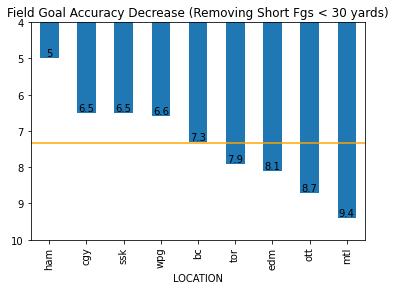

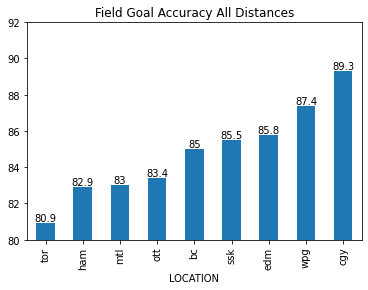

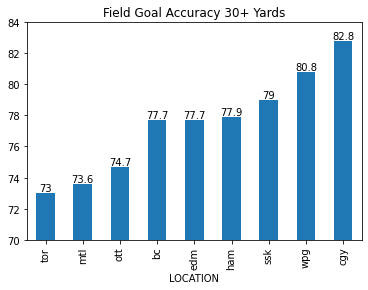

In [297]:
ax0 = df_fg_acc.sort_values(
      by=['ACCURACY_CHANGE_REMOVING_SHORT_FGS']
   ).plot.bar(
      title='Field Goal Accuracy Decrease (Removing Short Fgs < 30 yards)', 
      y=['ACCURACY_CHANGE_REMOVING_SHORT_FGS'],
      legend=False
   )
ax0.set_ylim(4,10)
ax0.axhline(df_fg_acc['ACCURACY_CHANGE_REMOVING_SHORT_FGS'].mean(), color='orange')
ax0.invert_yaxis()
for container in ax0.containers:
   ax0.bar_label(container)

ax1 = df_fg_acc.sort_values(
      by=['ALL_FGS']
   ).plot.bar(
      title='Field Goal Accuracy All Distances', 
      y=['ALL_FGS'], 
      legend=False
   )
ax1.set_ylim(80, 92)
for container in ax1.containers:
   ax1.bar_label(container)

ax3 = df_fg_acc.sort_values(
      by=['LONG_FGS']
   ).plot.bar(
      title='Field Goal Accuracy 30+ Yards', 
      y=['LONG_FGS'], 
      legend=False
   )
ax3.set_ylim(70, 84)
for container in ax3.containers:
   ax3.bar_label(container)



After removing short range, high percentage field goals, and plotting the results, we can see that there is a large change in some locations. The average drop in accuracy was around 7.2%, the largest drop was in Montreal where the overall accuracy dropped 9.4% and the lowest drop was in Hamilton with 5%. We can see the relative change in positions in the second and third charts. The removal of short field goals moved Hamiltons overall performance from 8th up to 4th. Edmonton dropped from 3rd to 5th. Calgary retained top spot and Toronto kept last place as well. The rest of the locations stayed in similar ranking moving only one spot at most. Using sklearn's standard scaler helps to visualise the positive and negative changes. Below we can see that Montreal and Ottawa had the biggest drops while Hamilton had the smallest while the rest of the field stayed relatively close to the average. From this change we can infer that Hamilton had the smallest proportion of field goals under 30 yards while Montreal and Ottawa had the highest amount. 

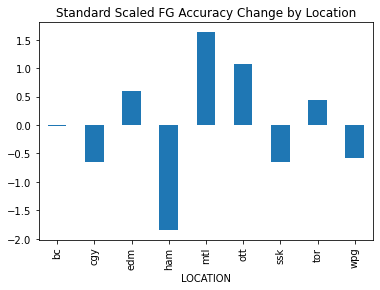

In [298]:
# Standard Scaler
standard_scaler = preprocessing.StandardScaler()
fg_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(df_fg_acc), columns=df_fg_acc.columns)
fg_standard_scaled['LOCATION'] = df_fg_acc.index
ax5 = fg_standard_scaled.plot.bar(
      x='LOCATION',
      y=['ACCURACY_CHANGE_REMOVING_SHORT_FGS'], 
      title='Standard Scaled FG Accuracy Change by Location',
      legend=False
   )


# Home vs Away Performance by Location
With the new detailed data, we can see how each location's home kicker compared to the visiting kickers. This will allow us to analyze how the home kicker can affect the results as presumed in the initial analysis. 

OVERALL LONG FG ACCURACY HOME VS AWAY
AWAY ACCURACY:  77.5 
HOME ACCURACY:  77.4


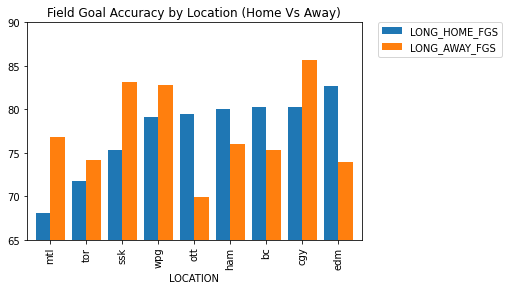

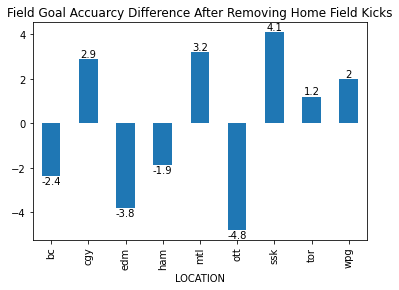

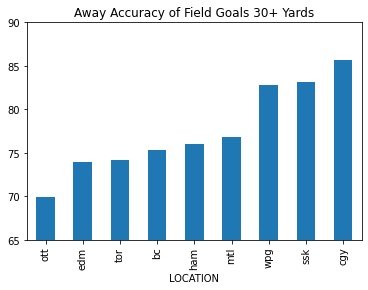

In [573]:
ax2 = df_fg_acc.sort_values(
      by=['LONG_HOME_FGS']
   ).plot.bar(
      title='Field Goal Accuracy by Location (Home Vs Away)', 
      y=['LONG_HOME_FGS', 'LONG_AWAY_FGS'], 
      width=0.8
   )
ax2.set_ylim(65, 90)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax3 = df_fg_acc.plot.bar(
      title='Field Goal Accuarcy Difference After Removing Home Field Kicks', 
      y=['DIFF_REMOVING_HOME_KICKERS'], 
      legend=False
   )

for container in ax3.containers:
   ax3.bar_label(container)

ax4 = df_fg_acc.sort_values(by=['LONG_AWAY_FGS']
   ).plot.bar(
      title='Away Accuracy of Field Goals 30+ Yards',
      y=['LONG_AWAY_FGS'],
      legend=False
)
ax4.set_ylim(65,90)

#Look at overall home field goal accuarcy and away field goal accuracy\
print('OVERALL LONG FG ACCURACY HOME VS AWAY')
print('AWAY ACCURACY: ',df_fg_acc.LONG_AWAY_FGS.mean().round(1), 
   '\nHOME ACCURACY: ', df_fg_acc.LONG_HOME_FGS.mean().round(1))


## Results
Looking at the results of plotting a location's home kicker's results compared to away we can see there can be significant differences. The first graph shows the difference between home field accuracy and away accuracy at each location. Montreal, Toronto, Saskatchewan, Winnipeg, and Calgary all had lower home field accuracy than the vistiing kickers. Ottawa, Hamilton, BC and Edmonton all had higher accuracy from the home field kickers, the most significant being Ottawa and Edmonton. The next plot shows the increase or decrease from overall accuracy at each location once the home kickers stats are removed. We can see that BC, Edmonton, Hamilton, Ottawa kickers all increased the overall accuarcy at their home stadiums. Removing the home field kicker from Ottawa resulted in a decreased accuracy of 4.8% and Edmonton 3.8%. Saskatchewan saw an increase in accuracy of 4.1% and Montreal and Calgary also saw a large increase in accuracy. This shows that the home field kicker can significantly skew the accuracy at a certain location due to their larger amount of attempts. 

Whats also worth noting is when we get the overall accuarcy for home kickers and visiting kickers they are almost identical. Long range field goal accuracy for home kickers was 77.4% and away kickers were accurate 77.5% of the time. Home field advantage does not appear to have any affect on accuarcy as a whole across the league. While location to location the home kicker may or may not out perform visitors, overall field goal accuarcy is the same. This could indicate that the overall most important factor in determining the success of the kick is the kicker himself rather than being home or away.

# Geographic Factors: Elevation, Temperature, Latitude
After looking at the preliminary plots, the data showed that the longest kickoff averages were in Calgary and shortest were in BC, it made sense to look at whether or not elevation plays a factor in kickoff distance.  Calgary is near the Rocky Mountains and is the highest elevation city in the CFL while BC is located in Vancouver on the coast, having the lowest elevation. Using the current kickoff data and then including the elevation above sea level in the data for each location, we can then see if there is any correlation between elevation and kickoff average. Calgary also showed having the best performance for punting and field goals as well so we will look at these as well. Temperature can also play a factor as colder weather actually increases air density which again could reduce distance of the ball kicked. I would expect these factors to show up in kickoffs and punting but field goal accuarcy I don't expect to change much as teams won't attempt field goals if they are out of the range. Kickers will guage their range for each game and generally only attempt that which is in their range. So if it's a particularily cold game affecting distance of the kick, they will attempt shorter kicks and accuarcy could stay similar then. I wanted to look at latitude as well as a proxy for temperature, the more north generally the colder. 

Elevations for each stadium were taken from https://en-ca.topographic-map.com/ and are in meters above sea level.  

Weather is collected from https://climate.weather.gc.ca/ and the data for weather is the average daily temperature in September for 1981 - 2010. I chose the month of september as that is the halfway point of the CFL season. 

Latitude is collected from google maps. 

In [438]:
df_temp_elevate = dn_away_only.copy()
elevations = [11, 1102, 662, 89, 70, 72, 580, 82, 232]
temperatures = [14.9, 11.0, 11.4, 15.8, 14.1, 15.0, 11.8, 17.2, 12.7]
latitudes = [49.2827,51.0447,53.5461, 43.2557, 45.5017, 45.4215, 50.4452, 43.6532, 49.8951]

df_temp_elevate['LOCATION'] = df_temp_elevate.index

df_temp_elevate['TEMPERATURE'] = temperatures
df_temp_elevate['ELEVATION'] = elevations
df_temp_elevate['LATITUDE'] = latitudes

df_temp_elevate['FG_ACCURACY_AWAY'] = df_fg_acc['LONG_AWAY_FGS'].to_numpy()

df_temp_elevate


,PUNT_AVG_AWAY,FG_ACCURACY_AWAY,KO_AVG_AWAY,TEMPERATURE,ELEVATION,LOCATION,LATITUDE
LOCATION,,,,,,,
BC,44.0,75.3,61.8,14.9,11,BC,49.2827
CGY,45.8,85.7,66.0,11.0,1102,CGY,51.0447
EDM,43.6,73.9,62.5,11.4,662,EDM,53.5461
HAM,43.6,76.0,63.9,15.8,89,HAM,43.2557
MTL,43.9,76.8,62.7,14.1,70,MTL,45.5017
OTT,45.0,69.9,65.5,15.0,72,OTT,45.4215
SSK,44.2,83.1,66.0,11.8,580,SSK,50.4452
TOR,44.1,74.2,64.4,17.2,82,TOR,43.6532
WPG,45.5,82.8,62.3,12.7,232,WPG,49.8951


## Detecting Multicollinearity with VIF (Variance Inflation Factor)
In order to make sure these independant variables being tested don't have high correlation amongst themselves. I wanted to make sure that elevation and latitude or temperature weren't capturing the same effect. It would make sense for temperature and latitude to be highly correlated as the further north you go the colder it should get. Looking at the results of using statsmodels' variance inflation factor package, we see that as predicted latitude and temperature are highly correlated while elevation does not appear to have much correlation with either of those metrics. While temperature varies throughout the season latitude does not and using this as a variable to capture the effects of temperature may be more consistent. 

In [461]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
   X = X[['TEMPERATURE', 'ELEVATION','LATITUDE']]
   # Calculating VIF
   # VIF dataframe
   vif_data = pd.DataFrame()
   vif_data["feature"] = X.columns
   
   # calculating VIF for each feature
   vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

   return(vif_data)
   
calc_vif(df_temp_elevate)

,feature,VIF
0,TEMPERATURE,59.438104
1,ELEVATION,5.281309
2,LATITUDE,79.764493


## Kickoff vs Elevation

In [516]:
def add_point_labels(plt, df, y_axis, x_axis, distance):
   for i in range(df.shape[0]):
      plt.text(x=df[x_axis][i]+distance,y=df[y_axis][i]+distance,s=df.LOCATION[i], 
      fontdict=dict(color='red',size=10),
      bbox=dict(facecolor='yellow',alpha=0.5))

def get_linear_regression_data(df, y_axis, x_axis):
   x = (df[x_axis].values).reshape(-1,1)
   y = df[y_axis].values.reshape(-1,1)
   model = LinearRegression().fit(x,y)
   r2 = model.score(x,y).round(3)
   slope = model.coef_[0][0].round(7)
   intercept = model.intercept_[0]
   y_pred = model.predict([[0]])
   # print('LINEAR REGRESSION OUTPUT FOR:\n', x_axis, y_axis, '\nR2: ', r2, '\n Slope: ', slope, '\n Intercept: ', intercept)
   df_append = pd.DataFrame([[r2, intercept, slope]], columns=['R2','Intercept','Slope'], index=[y_axis])
   return df_append
   


In [561]:
df_lr_ko = get_linear_regression_data(df_temp_elevate, 'KO_AVG_AWAY', 'ELEVATION')
df_lr_punt = get_linear_regression_data(df_temp_elevate, 'PUNT_AVG_AWAY', 'ELEVATION')
df_lr_fg = get_linear_regression_data(df_temp_elevate, 'FG_ACCURACY_AWAY', 'ELEVATION')
df_elevate_lr = df_lr_ko.append(df_lr_punt).append(df_lr_fg)
print('ELEVATION LINEAR REGRESSION TABLE')
df_elevate_lr

ELEVATION LINEAR REGRESSION TABLE


,R2,Intercept,Slope
KO_AVG_AWAY,0.209,63.250795,0.002015
PUNT_AVG_AWAY,0.174,44.118772,0.000907
FG_ACCURACY_AWAY,0.412,74.667044,0.008861


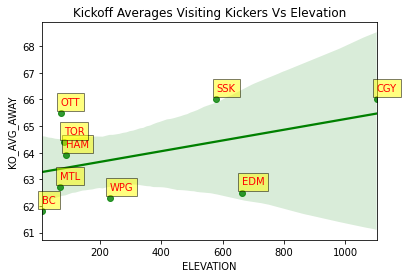

In [569]:
sns.regplot(
      y=df_temp_elevate['KO_AVG_AWAY'], 
      x=df_temp_elevate['ELEVATION'], 
      color='green',
      ci=95
   ).set_title('Kickoff Averages Visiting Kickers Vs Elevation')


add_point_labels(plt, df_temp_elevate, 'KO_AVG_AWAY', 'ELEVATION', 0.3)

In [560]:
# sns.regplot(
#       y=df_temp_elevate['KO_AVG_AWAY'], 
#       x=df_temp_elevate['ELEVATION'], 
#       color='green',
#       ci=None,
#       logx=True
#    ).set_title('Kickoff Averages Visiting Kickers Vs Elevation')


# add_point_labels(plt, df_temp_elevate, 'KO_AVG_AWAY', 'ELEVATION', 0.3)

Text(0.5, 1.0, 'Kickoff Averages Visiting Kickers Vs Elevation')

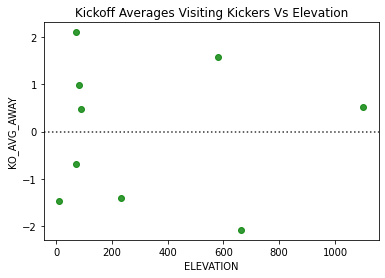

In [519]:
sns.residplot(
      y=df_temp_elevate['KO_AVG_AWAY'], 
      x=df_temp_elevate['ELEVATION'], 
      color='green',
   ).set_title('Kickoff Averages Visiting Kickers Vs Elevation')


## Punting vs Elevation

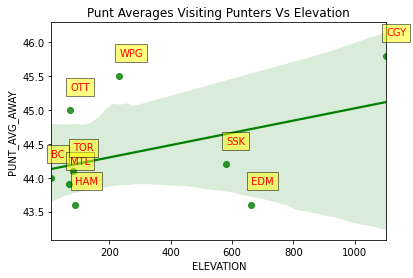

In [568]:
sns.regplot(
      y=df_temp_elevate['PUNT_AVG_AWAY'], 
      x=df_temp_elevate['ELEVATION'], 
      color='green',
      ci=95
   ).set_title('Punt Averages Visiting Punters Vs Elevation')

add_point_labels(plt, df_temp_elevate, 'PUNT_AVG_AWAY', 'ELEVATION', 0.3)



Text(0.5, 1.0, 'Risidual Plot: Punt Averages Visiting Punters Vs Elevation')

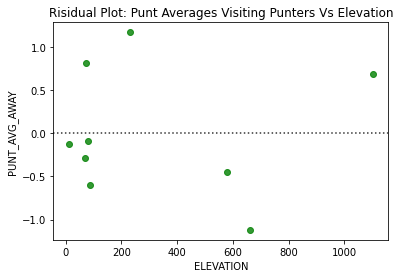

In [482]:
sns.residplot(
      y=df_temp_elevate['PUNT_AVG_AWAY'], 
      x=df_temp_elevate['ELEVATION'], 
      color='green',
   ).set_title('Risidual Plot: Punt Averages Visiting Punters Vs Elevation')

## Field Goal Accuracy vs Elevation

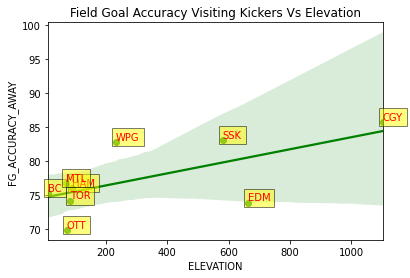

In [567]:
sns.regplot(
      y=df_temp_elevate['FG_ACCURACY_AWAY'], 
      x=df_temp_elevate['ELEVATION'], 
      color='green',
      ci=95
   ).set_title('Field Goal Accuracy Visiting Kickers Vs Elevation')

add_point_labels(plt, df_temp_elevate, 'FG_ACCURACY_AWAY', 'ELEVATION', 0.3)

Text(0.5, 1.0, 'Field Goal Accuracy Visiting Kickers Vs Elevation')

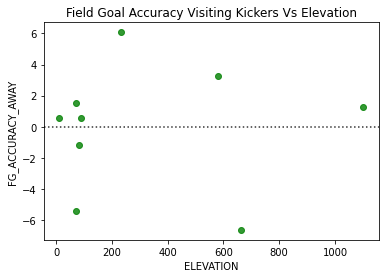

In [484]:
sns.residplot(
      y=df_temp_elevate['FG_ACCURACY_AWAY'], 
      x=df_temp_elevate['ELEVATION'], 
      color='green',
   ).set_title('Field Goal Accuracy Visiting Kickers Vs Elevation')

To analyse kicking performance and elevation, I plotted each of the kick types averages in each location, against elevation. Using seaborn’s regplot, this shows the data with a calculated linear regression model fitted in the plot itself. For each plot we see a positive slope associated with elevation so they are positively correlated. How strong the relationship is varies between the disciplines. Each linear regression is then calculated and the parameters are put into a table to see the associated values. A residual plot is shown for each model as well, this helps to visually  see if there is any bias in the regression. Each of the plots appears to show a random distribution of residuals about 0 indicating no bias. The R-squared value is the goodness of fit and in this case tells us how good elevation is at explaining the variance in each kicking performance type. Punt had the lowest at 17.4% and field goal the highest at 41.2% which is quite significant. This means that elevation can explain 41% of the variation in field goal accuracy. The intercepts show the expected performance metric if elevation is 0. The slope shows the effect on kicking performance for each 1m increase above sea level. For easier interpretation, I scaled the slope up to represent a 100m increment increase above sea level. We can see that for every 100m increase kick off average increases by 0.2 yards, punt average by 0.09 yards, and field goal accuracy increases by 0.9%. So for Calgary, where the elevation is 1102m, kickoff average increases by 2.2 yards, punt average by 1 yard, and field goal accuracy increases by 9.8% compared to sea level. 

# **Latitude Analysis**







In [510]:
df_punt_lr_lat = get_linear_regression_data(df_temp_elevate, 'PUNT_AVG_AWAY', 'LATITUDE')
df_fg_lr_lat = get_linear_regression_data(df_temp_elevate, 'FG_ACCURACY_AWAY', 'LATITUDE')
df_ko_lr_lat = get_linear_regression_data(df_temp_elevate, 'KO_AVG_AWAY', 'LATITUDE')
df_lat_lr = df_punt_lr_lat.append(df_fg_lr_lat).append(df_ko_lr_lat)
df_lat_lr

,R2,Intercept,Slope
PUNT_AVG_AWAY,0.058,41.814219,0.054096
FG_ACCURACY_AWAY,0.207,46.263740,0.651149
KO_AVG_AWAY,0.012,66.293757,-0.049865


From the table we can see that punt and kickoff have a very low R-squared value and therefore don't explain much variation in the data. But field goal accuracy has a R-squared of 20.7% which is quite significant. Because of the low R-squared I will only show the plot with the linear regression for field goal accuracy. We can see a couple outliers in Ottawa and Edmonton. The residual plot doesn't show any bias. There is a positive slope of 0.65 meaning that for every degree latitude increase, we expect field goal accuarcy to increase by 0.65. The intercept in this case would tell us that at a latitude of 0 degrees, which is the equator, we would expect field goal accuarcy to be 46% which is unlikely. The latitude in this case is used as a proxy for temperature. However with the positive slope we find that as you travel further north into colder climates, accuracy actually increases. 

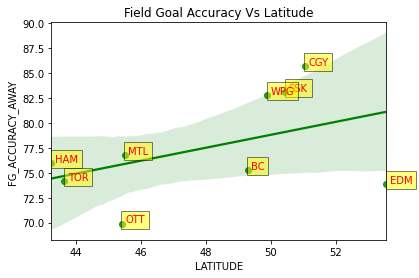

In [566]:
sns.regplot(
      y=df_temp_elevate['FG_ACCURACY_AWAY'], 
      x=df_temp_elevate['LATITUDE'], 
      color='green',
      ci=95
   ).set_title('Field Goal Accuracy Vs Latitude')

add_point_labels(plt, df_temp_elevate, 'FG_ACCURACY_AWAY', 'LATITUDE', 0.1)

Text(0.5, 1.0, 'Residual Plot: Field Goal Accuracy Vs Latitude')

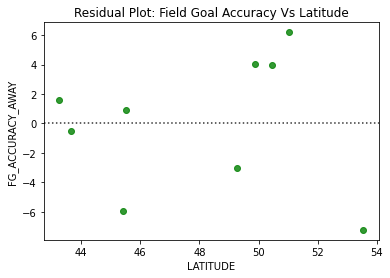

In [506]:
sns.residplot(
      y=df_temp_elevate['FG_ACCURACY_AWAY'], 
      x=df_temp_elevate['LATITUDE'], 
      color='green',
   ).set_title('Residual Plot: Field Goal Accuracy Vs Latitude')

# **Temperature Analysis**


In [511]:
df_punt_lr_temp = get_linear_regression_data(df_temp_elevate, 'PUNT_AVG_AWAY', 'TEMPERATURE')
df_fg_lr_temp = get_linear_regression_data(df_temp_elevate, 'FG_ACCURACY_AWAY', 'TEMPERATURE')
df_ko_lr_temp = get_linear_regression_data(df_temp_elevate, 'KO_AVG_AWAY', 'TEMPERATURE')
df_temp_lr = df_punt_lr_temp.append(df_fg_lr_temp).append(df_ko_lr_temp)
df_temp_lr

,R2,Intercept,Slope
PUNT_AVG_AWAY,0.141,46.376541,-0.142767
FG_ACCURACY_AWAY,0.410,98.789434,-1.544834
KO_AVG_AWAY,0.020,65.387987,-0.108086


In [521]:
# check difference if remove BC as indoor stadium climate controlled
df_temp_elevate_nobc = df_temp_elevate.drop('BC')
df_punt_lr_temp_nobc = get_linear_regression_data(df_temp_elevate_nobc, 'PUNT_AVG_AWAY', 'TEMPERATURE')
df_fg_lr_temp_nobc = get_linear_regression_data(df_temp_elevate_nobc, 'FG_ACCURACY_AWAY', 'TEMPERATURE')
df_ko_lr_temp_nobc = get_linear_regression_data(df_temp_elevate_nobc, 'KO_AVG_AWAY', 'TEMPERATURE')
df_temp_lr_nobc = df_punt_lr_temp_nobc.append(df_fg_lr_temp_nobc).append(df_ko_lr_temp_nobc)
df_temp_lr_nobc

,R2,Intercept,Slope
PUNT_AVG_AWAY,0.124,46.286236,-0.133852
FG_ACCURACY_AWAY,0.396,98.618679,-1.527976
KO_AVG_AWAY,0.003,64.671694,-0.037372


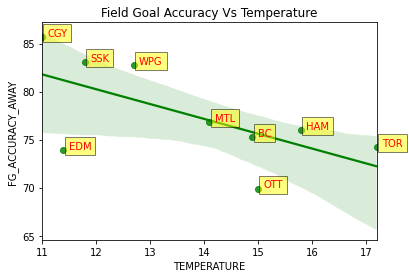

In [565]:
sns.regplot(
      y=df_temp_elevate['FG_ACCURACY_AWAY'], 
      x=df_temp_elevate['TEMPERATURE'], 
      color='green',
      ci=95, 
      # robust=True
   ).set_title('Field Goal Accuracy Vs Temperature')

add_point_labels(plt, df_temp_elevate, 'FG_ACCURACY_AWAY', 'TEMPERATURE', 0.1)

We find similar results to latitude here when looking at temperature which is expected as the two variables showed higher levels of correlation. Kickoff showed negligable effects from temperature while punt had an R-squared of 14.1% and field goal accuracy a fairly high 41.0%. This is higher than the R-squared values caputured comparing latitude so it would seem that this is a better independent variable. Again as temperature increases field goal accuarcy declines. The slope is measured at -1.54 so for every 1 degree Celcius increase in temperature, field goal accuarcy decreases 1.54%. Again Edmonton and Ottawa appear to be outliers for the data. 
With BC being indoors, we could infer that BC's outdoor average temperature may not play a factor in the results so I ran all the regressions with BC excluded to see if that changed anything in the results. However, the results stayed fairly consistent with the regression parameters. This is not surprising looking at the graph and seeing that BC is very close to the line of best fit, and not an outlier, so it's removal would have less impact on the model as a whole. 

# Jetlag West Travel to East
"The American Academy of Sleep Medicine defines jet lag as a syndrome involving insomnia or excessive daytime sleepiness following travel across at least 2 time zones."(1) Travelling long distances is considered to be a disadvantage for the opposing team. I am interested in looking into the performances of field goal kickers from the detailed data to see if this afffect can be seen. The detailed kicking data conttains which team the kicker is on and the location of the gamee making it easy to see if they traveled and how far. Because jetlag is defined as 2 or more timezones traveled, I split the data into 2 or more timezones traveled east, and then two or more timezones west, and then travel within 1 timezone or less. Travel direction is also split, as the study notes "travel across timezones, especially eastward, disrupts the diurnal rhythm. As a result, symptoms of jet lag andd sleep disturbances are worse after eastward flights than after westward flights."(2) CFL teams are spread across Canada in 4 different timezones. BC is the lone team in the Pacific timezone, the west most timezone which is 3 timezones from all the Eastern timezone teams (Montreal, Toronto, Hamilton and Ottawa) and vice versa. Calgary and Edmonton are in the Mountain Daylight timezone  are 2 timezones away from the Eastern teams and vice versa. Winnipeg is two timezones away from BC but only one from Eastern teams. Saskatchewan's team is in the Central Standard timezone which is the only timezone that does not follow daylight savings so half of the year they are the same as Calgary and Edmonton and the other half they are in line with Winnipeg. I do not have data on when each kick took place so for the purposes of this analysis we will only include Saskatchewan in the 1 timezone or less category when they travel to Winnipeg, Calgary or Edmonton. Otherwise I am unable to determine how many timezones away they were whene traveling to any of the other teams, it could be either 1 or 2. 

 1. American Academy of Sleep Medicine The International Classification of Sleep Disorders: Diagnostic and Coding Manual. 2nd ed. Westchester, IL: American Academy of Sleep Medicine; 2005
 2. Lee A, Galvez JC. Jet lag in athletes. Sports Health. 2012;4(3):211-216. doi:10.1177/1941738112442340






In [522]:
def get_fgs_of_team_in_loc(df, kickers_teams, away_stadiums):
   home_kicker_df = df[df.TEAM.isin(kickers_teams)]
   home_kicker_df = home_kicker_df[home_kicker_df.HOME.isin(away_stadiums)]
   return home_kicker_df
   

# WEST TO EAST TRAVEL 2+ TIMEZONES TRAVELED
bc_ab_to_ont_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['BC','EDM','CGY'], ['TOR','OTT','MTL','HAM'])
bc_to_wpg_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['BC'], ['WPG'])
# combine
west_to_east_travel = pd.concat([bc_ab_to_ont_travel, bc_to_wpg_travel])

# EAST TO WEST TRAVEL 2+ TIMEZONES TRAVELED
ont_to_ab_bc_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['TOR','OTT', 'MTL', 'HAM'], ['BC','EDM','CGY'])
wpg_to_bc_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['WPG'], ['BC'])
# combine
east_to_west_travel = pd.concat([ont_to_ab_bc_travel, wpg_to_bc_travel])

# LOCAL TRAVEL - 0-1 TIMEZONES TRAVELED
bc_ab_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['BC','EDM','CGY'], ['BC','EDM','CGY'])
ab_sask_wpg_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['EDM','CGY','SSK','WPG'], ['EDM','CGY','SSK','WPG'])
wpg_ont_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['TOR','OTT','MTL','HAM','WPG'], ['TOR','OTT','MTL','HAM','WPG'])
# combine
one_timezone_travel = pd.concat([bc_ab_travel, ab_sask_wpg_travel, wpg_ont_travel])


fg_acc_west_to_east_travel = get_accuracy(west_to_east_travel) 
fg_acc_east_to_west_travel = get_accuracy(east_to_west_travel) 
fg_acc_one_timezone_travel = get_accuracy(one_timezone_travel)
fg_acc_no_travel_home = get_accuracy(home_long_fg_data)





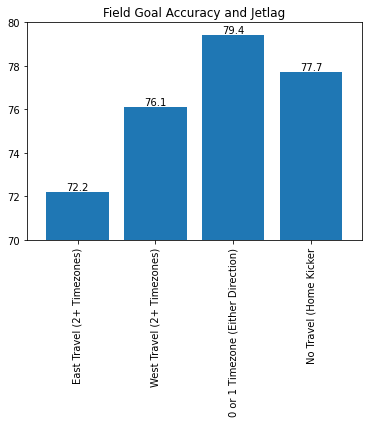

In [524]:
jetlag_index = [
   'East Travel (2+ Timezones)', 
   'West Travel (2+ Timezones)', 
   '0 or 1 Timezone (Either Direction)', 
   'No Travel (Home Kicker'
]

jetlag_df = pd.DataFrame(
   data={'FG_ACCURACY': [
      fg_acc_west_to_east_travel,
      fg_acc_east_to_west_travel,
      fg_acc_one_timezone_travel,
      fg_acc_no_travel_home
   ]}, 
   index=jetlag_index
)

ax4 = jetlag_df.plot.bar(
   title='Field Goal Accuracy and Jetlag', 
   width=0.8, 
   legend=False
)
ax4.set_ylim(70, 80)
for container in ax4.containers:
   ax4.bar_label(container)

The results of the analysis are in line with what was found in the study. We see that travel with no jetlag, so 1 or less timezones, resulted in the greatest field goal accuracy at 79.4% for field goals 30 yards and over. Jetlag associated with westward travel of 2 timezones or more had an accuracy of 76.1% and jetlag of eastward travel had the lowest accuracy of 72.2%. This is very interesting to see as it lines up quite precisely with the expected results. I also plotted overall home kicker accuracy which was 77.7%, which was between no jetlag travel and west traveling jetlag. Overall jetlag from eastward travel resulted in a decline in field goal accuracy of 7.2% when compared to non jetlag travel. 

## **Summary**
Examining the data from the Canadian Football League kicking performances of the last 4 years has had interesting results. Originally the goal was to analyse if there were any boosts to kicking performances from an indoor stadium compared to the outdoor stadiums. The data analysis showed there were no clear advantages as both field goal accuracy and punt average were essentially the same. When it comes to kickoffs however, BC was actually the worst stadium in the league for kickoff performance. 

This examination removed all the home field kickers so that the data had more even weights across individual kickers and was not skewed by the home kickers' much greater volume of kicks and therefore data points at each location. Removing the home team kickers from the data was compared to having it in for each location and while some stadiums remained similar, some had drastic changes in performance. BC’s punt average dropped the most. Edmonton’s field goal accuracy dropped significantly while Saskatchewan’s increased. Montreal saw a large dropoff in kickoff average along with Winnipeg while Saskatchewan increased. It was clear that individual kicker’s had a large effect on the overall average at each location and so they were removed for future analysis.

Analysis of the individual stadiums yielded a clear winner in kicking performances in Calgary. Calgary had the top results for field goal accuracy, punt average and kick off average. BC had the worst kickoff average, Edmonton the worst punt average, and Toronto the worst field goal accuracy. When looking at all three kick types, Calgary, Saskatchewan and then Winnipeg were top for aggregate performance while Edmonton, Hamilton, BC and Montreal were the bottom. Specifically looking at aggregate performance of punt and field goal the top three stayed the same but the bottom separated to Hamilton, Edmonton and Toronto being the toughest stadiums to perform in. 

When looking at individual performances as a metric vs overall aggregate this generally further increased the gap between the top performers and bottom in punt average. Calgary and Winnipeg remained on top while Edmonton, Toronto and Hamilton stayed at the bottom. Field goal accuracy showed larger changes, especially in Saskatchewan where several poor individual performances brought the average down from one of the top performers to being in the bottom half. Calgary further increased its lead while Hamilton jumped up into 3rd from amongst the bottom.

The addition of detailed kicking data with distances the field goal was attempted and made or missed allowed for further analysis. The data first was examined to see at what range field goal accuracy started to drop. Field goals under 30 yards were found to have 98% and above accuracy so they were removed from the data for the rest of the analysis to remove any bias from a stadium that happened by chance to have more shorter field goals kicked. Montreal had the biggest relative drop in accuracy, meaning the highest percentage of short field goals while Hamilton had the smallest, so the highest proportion of longer field goals 30 yards and over. 

The idea of home field advantage was analyzed, overall home field kicker field goal accuracy was essentially identical to away kicker accuracy. They were 77.4% and 77.5% respectively for field goals 30 yards and over so no advantage was found overall in the league. Home kicks were again removed to limit the effects of the home field kicker on the location data results. 

Geographic factors were looked at. Latitude, temperature and elevation. Elevation had a large effect on all three kick types and the biggest effect on field goal accuracy with elevation explaining 42% of the variance. All kick types performances were improved as elevation increased. This helps to explain Calgary’s dominance in all three kick types. This lines up with the research that air density decreases at higher altitudes reducing friction on the football in flight allowing for greater distance and lessening the effects of wind. 

Latitude had no effect on punt average or kickoff average but could explain 20% of variation in field goal accuracy. Field goal accuracy actually decreased the further south a stadium was which went against the theory that colder weather would decrease accuracy.  Temperature had similar results as temperature and latitude were found to be highly correlated. However temperature could explain 12.4% variation in punt average while latitude only explained 5.8% and R-squared for field goal accuracy doubled to 41% so temperature was a better explanatory variable overall than latitude. For field goal accuracy Edmonton and Ottawa were outliers. This again goes against the idea that colder weather would decrease accuracy and performance overall. One explanation is that in colder weather teams might not try longer, low percentage kicks, that they might otherwise in better conditions. 

Looking at jet lag as an indicator of performance yielded strong results. Traveling east 2 or more timezones resulted in a 7.2% decrease in accuracy of field goals 30 yards or over compared to kickers traveling within 1 time zone. West travel of 2 time zones or more again decreased accuracy but not as severely, only about half as much with a drop of 3.3% in accuracy. This gives eastern teams an advantage of they never have any eastern road trips while putting BC, the farthest west team at a significant disadvantage. These results are in line with research on jetlag and performance. 

## **Conclusion**
There was no advantage found to kicking indoors in BC compared to other stadiums in the league. Overall the best performing stadium is Calgary, leading all three categories of kicking. Elevation and temperature play a factor in this stadium's success. Jet lag also plays a factor. Calgary is located in a time zone where the furthest travel is from eastern teams and they will travel west and not suffer the full effects of jet lag. The other western teams are all within one time zone. The next best teams Saskatchewan and Winnipeg are also western conference teams centrally located in the country. 

The worst stadium to play in as a punter is Edmonton and then Toronto, Montreal and Hamilton. Edmonton is an outlier in that it is the only western stadium to be in the bottom 4. Edmonton is also 2nd last in field goal accuracy over 30 yards with last being Ottawa. This makes Edmonton a likely candidate for toughest stadium to play in. This could be due to its design of a sunken bowl stadium with no open ends. This makes for very challenging wind that swirls around in the stadium compared to other stadiums where the open ends generally allow for wind to funnel through. While still challenging these linear winds can be more consistent. 

Otherwise generally we find eastern teams and BC to be in the bottom 4 or 5 teams in each category with a couple exceptions. There is no clear worst stadium of these locations. Elevation and jet lag can help to explain this as eastern teams generally have lower elevations and 4 teams that must travel 2 time zones or more to play in the east. BC having the lowest elevation plus being three time zones away from eastern teams could explain its low ranking. 

## **Further Research**
Analysis could be extended to include more seasons in this analysis already completed to see if more data confirms or changes the results. Also extending this research to look at other types of players and their performances to see if similar results are found, especially around jet lag could be worth exploring. 


### References

Official site of the Canadian Football League. CFL.ca. (n.d.). https://www.cfl.ca/

Fowler PM, Knez W, Crowcroft S, Mendham AE, Miller J, Sargent C, Halson S, Duffield R. Greater Effect of East versus West Travel on Jet Lag, Sleep, and Team Sport Performance. Med Sci Sports Exerc. 2017 Dec;49(12):2548-2561. doi: 10.1249/MSS.0000000000001374. Erratum in: Med Sci Sports Exerc. 2018 Feb;50(2):391. Sargent, Charlie (corrected to Sargent, Charli). PMID: 28719491.

Mancini, M. (2018, December 24). Physics and Football: How Denver's Altitude Affects Field Goals. HowStuffWorks. https://entertainment.howstuffworks.com/physics-and-football-denvers-altitude-affect-field-goals.htm. 


